In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import json
import h5py

import windIO
import wind
import windWT as wt
import windCAD
import windOF as foam

import winsound

from matplotlib.ticker import FuncFormatter

## Basic definitions

In [3]:
les_dir = r"D:/tempData_depot/simData_CandC/wt_tngE2_final/main_r0/"

dir_wtVl_tngE2 = r"D:/tempData_depot/simData_CandC/wt_tngE2/"
dir_wtVl_tngE3 = r"D:/tempData_depot/simData_CandC/wt_tngE3/"

runIDs = ['p1', 'p2', 'p3', 'p4', 'p5',]

dir_wtCp_tngE2 = [r"E:/TNG/rawHFPI/tngE2"+x+"/" for x in runIDs]
dir_wtCp_tngE3 = [r"E:/TNG/rawHFPI/tngE3"+x+"/" for x in runIDs]

saveFigs = False
figDir = r"D:/tempData_depot/simData_CandC/__plots/blwt/"
if not os.path.exists(figDir):
    os.makedirs(figDir)

In [136]:
caseDictFile = les_dir+'masterCaseDict'
caseDictRaw = pd.read_csv(caseDictFile, index_col=None)
caseDict = {}
caseDict['AoAs'] = []
print(caseDictRaw.columns)
for i, (cDir, aoa) in enumerate(zip(caseDictRaw['caseName'], caseDictRaw['AoA'])):
    fullDir = les_dir+cDir
    if not os.path.isdir(fullDir):
        print('case not found: \t'+les_dir+cDir)
        caseDictRaw = caseDictRaw.drop(i)
        print('dropping case: \t\t'+cDir+'\n')
    else:
        if np.isnan(aoa):
            aoa = 'profile'  
        else:
            aoa = float(aoa)
            caseDict['AoAs'].append(aoa)
        caseDict[aoa] = {'dir':fullDir, 'probeName':caseDictRaw['probeName'][i]}
caseDictRaw = caseDictRaw.reset_index(drop=True)

print(caseDict)
print(caseDict['AoAs'])

Index(['caseName', 'AoA', 'probeName'], dtype='object')
case not found: 	D:/tempData_depot/simData_CandC/wt_tngE2_final/main_r0/tngE2.60d.m0.v0
dropping case: 		tngE2.60d.m0.v0

{'AoAs': [0.0, 10.0, 20.0, 40.0, 45.0, 50.0, 70.0, 80.0, 90.0], 'profile': {'dir': 'D:/tempData_depot/simData_CandC/wt_tngE2_final/main_r0/tngE2.ed.t3.r4a', 'probeName': 'prof_x0_y0'}, 0.0: {'dir': 'D:/tempData_depot/simData_CandC/wt_tngE2_final/main_r0/tngE2.00d.m0.v0', 'probeName': 'probes_WTtaps'}, 10.0: {'dir': 'D:/tempData_depot/simData_CandC/wt_tngE2_final/main_r0/tngE2.10d.m0.v0', 'probeName': 'probes_WTtaps'}, 20.0: {'dir': 'D:/tempData_depot/simData_CandC/wt_tngE2_final/main_r0/tngE2.20d.m0.v0', 'probeName': 'probes_WTtaps'}, 40.0: {'dir': 'D:/tempData_depot/simData_CandC/wt_tngE2_final/main_r0/tngE2.40d.m0.v0', 'probeName': 'probes_WTtaps'}, 45.0: {'dir': 'D:/tempData_depot/simData_CandC/wt_tngE2_final/main_r0/tngE2.45d.m0.v0', 'probeName': 'probes_WTtaps'}, 50.0: {'dir': 'D:/tempData_depot/simData_Ca

In [5]:
B = 0.2744
D = 0.183
lScl=1/50.0

Hr = 0.08  # ridge height
roofSlope = np.rad2deg(np.arctan(0.25/12))  # roof slope
He = Hr - D/2.0*np.sin(np.deg2rad(roofSlope))  # eaves height
Havg = np.mean([Hr, He])
H = Havg  # average roof height
print("Hr = {:.5g} m, He = {:.5g} m, Havg = {:.5g} m".format(Hr, He, Havg))

areaFactor_toFSm2 = (1/lScl**2)   # convert mm2 to m2 and normalize by the square of the length scale

badTaps = None
# badTaps = [1316, 1807, 2609,]


Hr = 0.08 m, He = 0.078094 m, Havg = 0.079047 m


## Building Geometry

In [6]:
tapFile = r"D:/tempData_depot/simData_CandC/tngTapDefinition.csv"
tapInfo = pd.read_csv(tapFile)

faceID = [1,2,3,4,5,6]
name = ['Roof_1','Roof_2','Wall_1','Wall_2','Wall_3','Wall_4']
note = ['','','','','','']
origin = [[0,0,0.08],
          [0,-0.0915,0.07809375],
          [-0.1372,0,0],
          [0,-0.0915,0],
          [0.1372,0,0],
          [0,0.0915,0],]
basisVectors = [[[1,0,0],[0,0.999783057,0.020828814],[0,-0.020828814,0.999783057]],
                [[1,0,0],[0,0.999783057,-0.020828814],[0,0.020828814,0.999783057]],
                [[0,0,-1],[-1,0,0],[0,1,0]],
                [[1,0,0],[0,0,-1],[0,1,0]],
                [[0,0,1],[1,0,0],[0,1,0]],
                [[-1,0,0],[0,0,1],[0,1,0]],]

origin_plt = [[0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              ]

basisVectors_plt = [[[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    ]
vertices = [[[-0.091519855,-0.1372],[0,-0.1372],[0,0.1372],[-0.091519855,0.1372],[-0.091519855,-0.1372]],
            [[0,-0.1372],[0.091519855,-0.1372],[0.091519855,0.1372],[0,0.1372],[0,-0.1372]],
            [[-0.0915,-0.2332],[0.0915,-0.2332],[0.0915,-0.15510625],[0,-0.1532],[-0.0915,-0.15510625],[-0.0915,-0.2332]],
            [[0.107519855,-0.1372],[0.185613605,-0.1372],[0.185613605,0.1372],[0.107519855,0.1372],[0.107519855,-0.1372]],
            [[-0.0915,0.2332],[0.0915,0.2332],[0.0915,0.15510625],[0,0.1532],[-0.0915,0.15510625],[-0.0915,0.2332]],
            [[-0.107519855,-0.1372],[-0.185613605,-0.1372],[-0.185613605,0.1372],[-0.107519855,0.1372],[-0.107519855,-0.1372]],]



In [7]:
# Zone Dict definitions

zoneDict_NBCC = [
        {    # Face 1
            0:['NBCC 2020', 'Zone c', np.array([[-0.091519855,-0.1372],[-0.071519855,-0.1372],[-0.071519855,-0.1172],[-0.091519855,-0.1172],[-0.091519855,-0.1372]])],
            1:['NBCC 2020', 'Zone c', np.array([[-0.091519855,0.1172],[-0.071519855,0.1172],[-0.071519855,0.1372],[-0.091519855,0.1372],[-0.091519855,0.1172]])],
            2:['NBCC 2020', 'Zone s', np.array([[-0.071519855,-0.1372],[0,-0.1372],[0,-0.1172],[-0.071519855,-0.1172],[-0.071519855,-0.1372]])],
            3:['NBCC 2020', 'Zone s', np.array([[-0.091519855,-0.1172],[-0.071519855,-0.1172],[-0.071519855,0.1172],[-0.091519855,0.1172],[-0.091519855,-0.1172]])],
            4:['NBCC 2020', 'Zone s', np.array([[-0.071519855,0.1172],[0,0.1172],[0,0.1372],[-0.071519855,0.1372],[-0.071519855,0.1172]])],
            5:['NBCC 2020', 'Zone r', np.array([[-0.071519855,-0.1172],[0,-0.1172],[0,0.1172],[-0.071519855,0.1172],[-0.071519855,-0.1172]])],
        },
        {   # Face 2
            0:['NBCC 2020', 'Zone c', np.array([[0.091519855,-0.1372],[0.071519855,-0.1372],[0.071519855,-0.1172],[0.091519855,-0.1172],[0.091519855,-0.1372]])],
            1:['NBCC 2020', 'Zone c', np.array([[0.091519855,0.1172],[0.071519855,0.1172],[0.071519855,0.1372],[0.091519855,0.1372],[0.091519855,0.1172]])],
            2:['NBCC 2020', 'Zone s', np.array([[0.071519855,-0.1372],[0,-0.1372],[0,-0.1172],[0.071519855,-0.1172],[0.071519855,-0.1372]])],
            3:['NBCC 2020', 'Zone s', np.array([[0.091519855,-0.1172],[0.071519855,-0.1172],[0.071519855,0.1172],[0.091519855,0.1172],[0.091519855,-0.1172]])],
            4:['NBCC 2020', 'Zone s', np.array([[0.071519855,0.1172],[0,0.1172],[0,0.1372],[0.071519855,0.1372],[0.071519855,0.1172]])],
            5:['NBCC 2020', 'Zone r', np.array([[0.071519855,-0.1172],[0,-0.1172],[0,0.1172],[0.071519855,0.1172],[0.071519855,-0.1172]])],
        },
        {   # Face 3
            0:['NBCC 2020', 'Zone e', np.array([[-0.0915,-0.2332],[-0.0715,-0.2332],[-0.0715,-0.154689583],[-0.0915,-0.15510625],[-0.0915,-0.2332]])],
            1:['NBCC 2020', 'Zone e', np.array([[0.0715,-0.2332],[0.0915,-0.2332],[0.0915,-0.15510625],[0.0715,-0.154689583],[0.0715,-0.2332]])],
            2:['NBCC 2020', 'Zone w', np.array([[-0.0715,-0.2332],[0.0715,-0.2332],[0.0715,-0.154689583],[0,-0.1532],[-0.0715,-0.154689583],[-0.0715,-0.2332]])],
        },
        {   # Face 4
            0:['NBCC 2020', 'Zone e', np.array([[0.107519855,-0.1372],[0.185613605,-0.1372],[0.185613605,-0.1172],[0.107519855,-0.1172],[0.107519855,-0.1372]])],
            1:['NBCC 2020', 'Zone e', np.array([[0.107519855,0.1172],[0.185613605,0.1172],[0.185613605,0.1372],[0.107519855,0.1372],[0.107519855,0.1172]])],
            2:['NBCC 2020', 'Zone w', np.array([[0.107519855,-0.1172],[0.185613605,-0.1172],[0.185613605,0.1172],[0.107519855,0.1172],[0.107519855,-0.1172]])],
        },
        {   # Face 5
            0:['NBCC 2020', 'Zone e', np.array([[-0.0915,0.2332],[-0.0715,0.2332],[-0.0715,0.154689583],[-0.0915,0.15510625],[-0.0915,0.2332]])],
            1:['NBCC 2020', 'Zone e', np.array([[0.0715,0.2332],[0.0915,0.2332],[0.0915,0.15510625],[0.0715,0.154689583],[0.0715,0.2332]])],
            2:['NBCC 2020', 'Zone w', np.array([[-0.0715,0.2332],[0.0715,0.2332],[0.0715,0.154689583],[0,0.1532],[-0.0715,0.154689583],[-0.0715,0.2332]])],
        },
        {   # Face 6
            0:['NBCC 2020', 'Zone e', np.array([[-0.107519855,-0.1372],[-0.185613605,-0.1372],[-0.185613605,-0.1172],[-0.107519855,-0.1172],[-0.107519855,-0.1372]])],
            1:['NBCC 2020', 'Zone e', np.array([[-0.107519855,0.1172],[-0.185613605,0.1172],[-0.185613605,0.1372],[-0.107519855,0.1372],[-0.107519855,0.1172]])],
            2:['NBCC 2020', 'Zone w', np.array([[-0.107519855,-0.1172],[-0.185613605,-0.1172],[-0.185613605,0.1172],[-0.107519855,0.1172],[-0.107519855,-0.1172]])],
        },
]

zoneDict_ASCE = [
        {    # Face 1
            0:['ASCE 7-22', 'Zone 3', np.array([[-0.0435, 0.1372], [-0.0915, 0.1372], [-0.0915, 0.0892], [-0.0755, 0.0892], [-0.0755, 0.1212], [-0.0435, 0.1212], [-0.0435, 0.1372], ])],
            1:['ASCE 7-22', 'Zone 3', np.array([[-0.0915, -0.0892], [-0.0915, -0.1372], [-0.0435, -0.1372], [-0.0435, -0.1212], [-0.0755, -0.1212], [-0.0755, -0.0892], [-0.0915, -0.0892], ])],
            2:['ASCE 7-22', 'Zone 2', np.array([[0, 0.1372], [-0.0435, 0.1372], [-0.0435, 0.1212], [-0.0755, 0.1212], [-0.0755, 0.0892], [-0.0915, 0.0892], [-0.0915, -0.0892], 
                                                [-0.0755, -0.0892], [-0.0755, -0.1212], [-0.0435, -0.1212], [-0.0435, -0.1372], [0, -0.1372], [0, -0.0892], [-0.0435, -0.0892], 
                                                [-0.0435, 0.0892], [0, 0.0892], [0, 0.1372], ])],
            3:['ASCE 7-22', 'Zone 1', np.array([[0, 0.0892], [-0.0435, 0.0892], [-0.0435, -0.0892], [0, -0.0892], [0, 0.0892], ])],
        },
        {   # Face 2
            0:['ASCE 7-22', 'Zone 3', np.array([[0.0435, 0.1372], [0.0915, 0.1372], [0.0915, 0.0892], [0.0755, 0.0892], [0.0755, 0.1212], [0.0435, 0.1212], [0.0435, 0.1372], ])],
            1:['ASCE 7-22', 'Zone 3', np.array([[0.0915, -0.0892], [0.0915, -0.1372], [0.0435, -0.1372], [0.0435, -0.1212], [0.0755, -0.1212], [0.0755, -0.0892], [0.0915, -0.0892], ])],
            2:['ASCE 7-22', 'Zone 2', np.array([[0, 0.1372], [0.0435, 0.1372], [0.0435, 0.1212], [0.0755, 0.1212], [0.0755, 0.0892], [0.0915, 0.0892], [0.0915, -0.0892], 
                                                [0.0755, -0.0892], [0.0755, -0.1212], [0.0435, -0.1212], [0.0435, -0.1372], [0, -0.1372], [0, -0.0892], [0.0435, -0.0892], 
                                                [0.0435, 0.0892], [0, 0.0892], [0, 0.1372], ])],
            3:['ASCE 7-22', 'Zone 1', np.array([[0, 0.0892], [0.0435, 0.0892], [0.0435, -0.0892], [0, -0.0892], [0, 0.0892], ])],
        },
        {   # Face 3
            0:['ASCE 7-22', 'Zone 4', np.array([[-0.0715,-0.2332],[0.0715,-0.2332],[0.0715,-0.154689583],[0,-0.1532],[-0.0715,-0.154689583],[-0.0715,-0.2332]])],
            1:['ASCE 7-22', 'Zone 5', np.array([[-0.0915,-0.2332],[-0.0715,-0.2332],[-0.0715,-0.154689583],[-0.0915,-0.15510625],[-0.0915,-0.2332]])],
            2:['ASCE 7-22', 'Zone 5', np.array([[0.0715,-0.2332],[0.0915,-0.2332],[0.0915,-0.15510625],[0.0715,-0.154689583],[0.0715,-0.2332]])],
        },
        {   # Face 4
            0:['ASCE 7-22', 'Zone 5', np.array([[0.107519855,-0.1372],[0.185613605,-0.1372],[0.185613605,-0.1172],[0.107519855,-0.1172],[0.107519855,-0.1372]])],
            1:['ASCE 7-22', 'Zone 5', np.array([[0.107519855,0.1172],[0.185613605,0.1172],[0.185613605,0.1372],[0.107519855,0.1372],[0.107519855,0.1172]])],
            2:['ASCE 7-22', 'Zone 4', np.array([[0.107519855,-0.1172],[0.185613605,-0.1172],[0.185613605,0.1172],[0.107519855,0.1172],[0.107519855,-0.1172]])],
        },
        {   # Face 5
            0:['ASCE 7-22', 'Zone 5', np.array([[-0.0915,0.2332],[-0.0715,0.2332],[-0.0715,0.154689583],[-0.0915,0.15510625],[-0.0915,0.2332]])],
            1:['ASCE 7-22', 'Zone 5', np.array([[0.0715,0.2332],[0.0915,0.2332],[0.0915,0.15510625],[0.0715,0.154689583],[0.0715,0.2332]])],
            2:['ASCE 7-22', 'Zone 4', np.array([[-0.0715,0.2332],[0.0715,0.2332],[0.0715,0.154689583],[0,0.1532],[-0.0715,0.154689583],[-0.0715,0.2332]])],
        },
        {   # Face 6
            0:['ASCE 7-22', 'Zone 5', np.array([[-0.107519855,-0.1372],[-0.185613605,-0.1372],[-0.185613605,-0.1172],[-0.107519855,-0.1172],[-0.107519855,-0.1372]])],
            1:['ASCE 7-22', 'Zone 5', np.array([[-0.107519855,0.1172],[-0.185613605,0.1172],[-0.185613605,0.1372],[-0.107519855,0.1372],[-0.107519855,0.1172]])],
            2:['ASCE 7-22', 'Zone 4', np.array([[-0.107519855,-0.1172],[-0.185613605,-0.1172],[-0.185613605,0.1172],[-0.107519855,0.1172],[-0.107519855,-0.1172]])],
        },
]

# file = caseDir+'NBCC_zoneDict.json'
# with open(file, 'w') as f:
#     json.dump(zoneDict,f, indent=4, separators=(',', ':'))

In [8]:
# nominalPanelAreas=[1.0e-4, 2.45e-4, 4.8e-4, 7.1e-4, 1e-3], #[5e-5, 8e-5, 1.5e-4, 5e-4]
# nominalPanelAreas=[4.4e-5, 8.15e-5, 1.3e-4, 5e-4, 6.8e-4, 1.3e-3,]  # Final! All are tested. 1.3e-3 results in blunt edge zones in the walls but no error.
nominalPanelAreas=[4.4e-5, 8.15e-5, 1.3e-4, 5.25e-4, 6.8e-4, 1.3e-3,]  # 5e-4 causes problems in ASCE 7-22 zone 2 
# nominalPanelAreas=[1.3e-3,]
# nominalPanelAreas=[4.8e-4, 7.2e-4, 1e-3]

faces_NBCC = []
for i,f in enumerate(faceID):
    idx = tapInfo.index[tapInfo.faceID == f]
    tapCoords = np.transpose(np.array([tapInfo.x[idx], tapInfo.y[idx]]))
    tapNos = np.array(tapInfo.tapNo[idx],dtype=int)
    idxOrig = idx

    fc = windCAD.face(
                name=name[i],
                ID=f,
                origin=origin[i],
                basisVectors=basisVectors[i],
                origin_plt=origin_plt[i],
                basisVectors_plt=basisVectors_plt[i],
                vertices=vertices[i],
                tapNo=tapNos,
                tapIdx=idxOrig,
                tapName=None,
                tapCoord=tapCoords,
                zoneDict=zoneDict_NBCC[i],
                nominalPanelAreas=nominalPanelAreas,
                numOfNominalPanelAreas=3,
                badTaps=badTaps,
                allBldgTaps=np.array(tapInfo.tapNo,dtype=int),
                )
    # fc.plot(figSize=[20,15], overlayPanels=True, overlayTaps=True, overlayTribs=True, overlayZones=True)
    faces_NBCC.append(fc)

faces_ASCE = []
for i,f in enumerate(faceID):
    idx = tapInfo.index[tapInfo.faceID == f]
    tapCoords = np.transpose(np.array([tapInfo.x[idx], tapInfo.y[idx]]))
    tapNos = np.array(tapInfo.tapNo[idx],dtype=int)
    idxOrig = idx

    fc = windCAD.face(
                name=name[i],
                ID=f,
                origin=origin[i],
                basisVectors=basisVectors[i],
                origin_plt=origin_plt[i],
                basisVectors_plt=basisVectors_plt[i],
                vertices=vertices[i],
                tapNo=tapNos,
                tapIdx=idxOrig,
                tapName=None,
                tapCoord=tapCoords,
                zoneDict=zoneDict_ASCE[i],
                nominalPanelAreas=nominalPanelAreas,
                numOfNominalPanelAreas=3,
                badTaps=badTaps,
                allBldgTaps=np.array(tapInfo.tapNo,dtype=int),
                )
    # fc.plot(figSize=[20,15], overlayPanels=True, overlayTaps=True, overlayTribs=True, overlayZones=True)
    faces_ASCE.append(fc)
# file = caseDir+'ttu_bldgGeom.json'
# allFaces.writeToFile(file_basic=file)

Generating panels ...


c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_pol

Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone c": {
        "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]": [],
        "tap idxs with weight errors": {
            "A=4.4e-05": [],
            "A=8.15e-05": [],
            "A=0.00013": [],
            "A=0.000525": [],
            "A=0.00068": [],
            "A=0.0013": []
        }
    },
    "NBCC 2020 -- Zone s": {
        "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]": [],
        "tap idxs with weight errors": {
            "A=4.4e-05": [],
            "A=8.15e-05": [],
            "A=0.00013": [],
            "A=0.000525": [],
            "A=0.00068": [],
            "A=0.0013": []
        }
    },
    "NBCC 2020 -- Zone r": {
        "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]": [],
        "tap idxs with weight errors": {
            "A=4.4e-05": [],
     

c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_pol

Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone c": {
        "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]": [],
        "tap idxs with weight errors": {
            "A=4.4e-05": [],
            "A=8.15e-05": [],
            "A=0.00013": [],
            "A=0.000525": [],
            "A=0.00068": [],
            "A=0.0013": []
        }
    },
    "NBCC 2020 -- Zone s": {
        "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]": [],
        "tap idxs with weight errors": {
            "A=4.4e-05": [],
            "A=8.15e-05": [],
            "A=0.00013": [],
            "A=0.000525": [],
            "A=0.00068": [],
            "A=0.0013": []
        }
    },
    "NBCC 2020 -- Zone r": {
        "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]": [],
        "tap idxs with weight errors": {
            "A=4.4e-05": [],
     

In [9]:
bldg = wind.bldgCp(bldgName='TTU_1to50_TNG',
                faces=faces_ASCE,
                H=H,D=D,B=B,roofSlope=1.2,lScl=lScl,
                caseName='GeomDefinition',
                badTaps=badTaps,
                )
print(json.dumps(bldg.panelingErrors, indent=4, separators=(',', ':')))

Refreshing GeomDefinition...
Verifying data ...
Done refreshing GeomDefinition.

{
    "Face 1":{
        "ASCE 7-22 -- Zone 3":{
            "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]":[],
            "tap idxs with weight errors":{
                "A=4.4e-05":[],
                "A=8.15e-05":[],
                "A=0.00013":[],
                "A=0.000525":[],
                "A=0.00068":[],
                "A=0.0013":[]
            }
        },
        "ASCE 7-22 -- Zone 2":{
            "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]":[],
            "tap idxs with weight errors":{
                "A=4.4e-05":[],
                "A=8.15e-05":[],
                "A=0.00013":[],
                "A=0.000525":[],
                "A=0.00068":[],
                "A=0.0013":[]
            }
        },
        "ASCE 7-22 -- Zone 1":{
            "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05

### Plots

(-0.25651999999999997,
 0.25651999999999997,
 -0.20417496549999997,
 0.20417496549999997)

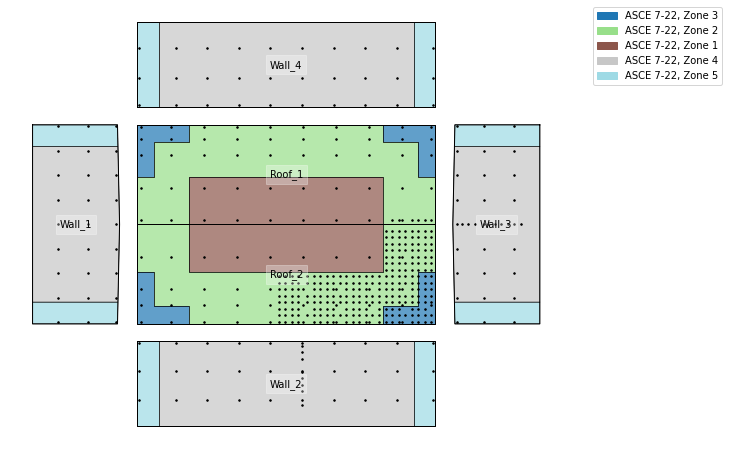

In [10]:
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot()

bldg.plotEdges(ax=ax,showName=True)
bldg.plotZones(ax=ax)
bldg.plotTaps(ax=ax)
# bldg.plotTribs(ax=ax)
# bldg.plotPanels(ax=ax,aIdx=2)

ax.axis('equal')
ax.axis('off')
# if saveFigs:
#     fig.savefig(figDir+"tapLayout.svg",format='svg',dpi=1200, bbox_inches='tight')



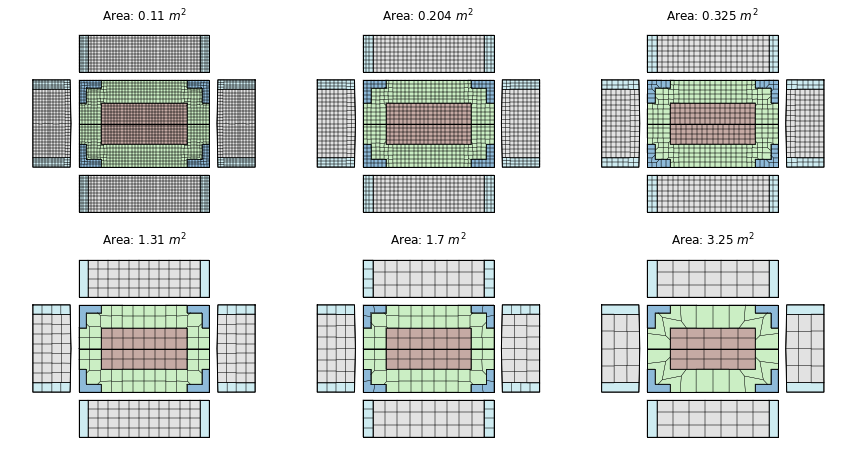

In [11]:

fig, axs = bldg.plotPanels_AllAreas(figsize=[12,6.4], nCols=3,
    areaUnit=r'$m^2$', areaFactor=areaFactor_toFSm2, areaFmt='{:2.3g}',
    )
# if saveFigs:
#     fig.savefig(figDir+"nominalPanelAreas_ASCE.svg",format='svg',dpi=1200, bbox_inches='tight')

## Wind field

### Read data

In [95]:
keepTH = True

temp = h5py.File(dir_wtVl_tngE2+"tngE2Fr1_forPython.mat", 'r')
wtVel_E2 = wind.profile(name="BLWT-E2", Z=temp['Z'][0][()],UofT=temp['UofT'][()],VofT=temp['VofT'][()],WofT=temp['WofT'][()],H=H,dt=temp['dt'][0][0],nSpectAvg=64, 
                        workSect_zLim=[0, 0.5], lScl=1/50,
                        keepTH=keepTH)

# temp = h5py.File(dir_wtVl_tngE3+"tngE3Fr1_forPython.mat", 'r')
# wtVel_E3 = wind.profile(name="BLWT-E3", Z=temp['Z'][0][()],UofT=temp['UofT'][()],VofT=temp['VofT'][()],WofT=temp['WofT'][()],H=H,dt=temp['dt'][0][0],nSpectAvg=64, keepTH=keepTH)


### LES wind field

In [96]:

lesVel_E2 = foam.readVelProfile(caseDir=caseDict['profile']['dir'], probeName=caseDict['profile']['probeName'],H=H, readFromNPY_file=True, writeToFile=True,
                                kwargs_profile={'workSect_zLim':[0, 0.5],  'lScl':1/50,})
lesVel_E2.name = "LES(z_0=0.01m)"

# lesVel_E3 = foam.processVelProfile(caseDir=dir_lesE3_00, probeName='probes.V1',H=H, trimTimeSegs=[[0,1.0]])
# lesVel_E3.name = "LES(z_0=0.087m)"

Processing OpenFOAM case:	D:/tempData_depot/simData_CandC/wt_tngE2_final/main_r0/tngE2.ed.t3.r4a
Probe read from:		D:/tempData_depot/simData_CandC/wt_tngE2_final/main_r0/tngE2.ed.t3.r4a/postProcessing/prof_x0_y0
  >> Reading probe data ...
  >> Reading data from NPY file.
             << Done!
  >> Processing profile data.
  >> Reading pressure data ...
  >> Reading data from NPY file.
             << Done!
  >> Finished reading probe data.


In [14]:
vel = wind.Profiles([wtVel_E2, lesVel_E2,])
esdu74_E2 = wind.ESDU74(z0=0.01, Zref=H/lScl, Uref=25.0, Z=np.logspace(-1,2,100))
esdu85_E2 = wind.ESDU74(z0=0.01, Zref=H/lScl, Uref=25.0, Z=np.logspace(-1,2,100))


### Plot wind field

In [15]:
wtZ = wtVel_E2.Z[:25]
wtIu = wtVel_E2.Iu[:25]
lesIu = np.interp(wtZ, lesVel_E2.Z, lesVel_E2.Iu)
err_E2_Iu = np.mean(np.abs(lesIu - wtIu))

print(err_E2_Iu)


0.014771862271235423


## Surface pressure, $C_p$

#### Wind tunnel data

In [16]:
analogChannels_idxs={
                'main_pitot': 0,
                'xref_pitot': 2,
            }
pressureExtraChannels_tapNos={
                'main_pitot_zero': 3009,
                'main_pitot_q': 3010,
                '20inch_pitot_zero': 3007,
                '20inch_pitot_q': 3008,
                'Uh_pitot_zero': 3005,
                'Uh_pitot_q': 3006,
            }

peakSpecs = wind.DEFAULT_PEAK_SPECS
peakSpecs['Num_seg'] = 16
peakSpecs['Duration'] = 16
peakSpecs['prob_non_excd'] = 0.8

mainRefPitotChnlIdx = 2
Zpitot = 1.48
Ntaps = 456
lowpassFreq=200.0

In [152]:
# cps_OP = []
i, rID = 0, runIDs[0]
# for i, rID in enumerate(runIDs):
print(">> Processing: OP-"+rID)
cp_raw = wt.BLWTL_HFPI(
    caseDir=dir_wtCp_tngE2[i],
    userNotes=None,
    Z_MainPitot=Zpitot,
    analogChannels_idxs=analogChannels_idxs,
    pressureExtraChannels_tapNos=pressureExtraChannels_tapNos,
    lowpassFreq=lowpassFreq,
    Ntaps=Ntaps,
    AoAsToRead=caseDict['AoAs'],
)
winsound.Beep(1000, 1000)
print("      Loaded raw data")
print(cp_raw.description)

print(cp_raw.CpTH.shape)

WT_cp = wind.bldgCp(
                bldgName=bldg.name,
                faces=bldg.faces,
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                AoA_zero_deg_basisVector=bldg.AoA_zero_deg_basisVector,
                AoA_rotation_direction=bldg.AoA_rotation_direction,
                caseName='OP_ASCE_C&C_'+rID,
                refProfile=wtVel_E2,
                Zref_input=cp_raw.Z_MainPitot,
                Uref_input=cp_raw.Uref,
                samplingFreq=cp_raw.sampleRate,
                AoA=cp_raw.AoA,
                CpOfT=cp_raw.CpTH,
                notes_Cp=cp_raw.description,
                badTaps=None,
                reReferenceCpToH=True,
                pOfT=None,
                p0ofT=None,
                CpStats=None,
                peakSpecs=peakSpecs,
                keepTH=False,
                )
winsound.Beep(1500, 1000)
print("      << Complete!")
# cps_OP.append(cp)

# del cp_raw, cp

>> Processing: OP-p1
Reading HFPI data from: E:/TNG/rawHFPI/tngE2p1/
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P001a.pssd
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P002a.pssd
       AoA 5.0 is not in the list of AoAs to read: [0.0, 10.0, 20.0, 40.0, 45.0, 50.0, 70.0, 80.0, 90.0]. Skipping.
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P003a.pssd
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P004a.pssd
       AoA 15.0 is not in the list of AoAs to read: [0.0, 10.0, 20.0, 40.0, 45.0, 50.0, 70.0, 80.0, 90.0]. Skipping.
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P005a.pssd
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P006a.pssd
       AoA 25.0 is not in the list of AoAs to read: [0.0, 10.0, 20.0, 40.0, 45.0, 50.0, 70.0, 80.0, 90.0]. Skipping.
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P007a.pssd
       AoA 30.0 is not in the list of AoAs to read: [0.0, 10.0, 20.0, 40.0, 45.0, 50.0, 70.0, 80.0, 90.0]. Skipping.
   Reading file: E:/TNG

#### Load CFD Cp

In [143]:
allPres = []
nmin = 1000000000000
tCutIdx = 5000
AoA_final = []
for i, aoa in enumerate(caseDict['AoAs']):
    pressure,probes,time = foam.readSurfacePressure(caseDir=caseDict[aoa]['dir'], probeName=caseDict[aoa]['probeName'], readFromNPY_file=True, writeToFile=True)
    if pressure.shape[1] >= tCutIdx:
        allPres.append(pressure)
        AoA_final.append(aoa)
        print(pressure.shape)
        nmin = min(nmin, pressure.shape[1])

# nmin = tCutIdx

# allPressure = np.empty((len(allPres), allPres[0].shape[0], nmin))
for i in range(len(allPres)):
    allPres[i] = allPres[i][:, :nmin]
    # allPressure[i,:,:] = allPres[i][:, :nmin]

allPressure = np.array(allPres)

print(allPressure.shape)

Processing OpenFOAM case:	D:/tempData_depot/simData_CandC/wt_tngE2_final/main_r0/tngE2.00d.m0.v0
Probe read from:		D:/tempData_depot/simData_CandC/wt_tngE2_final/main_r0/tngE2.00d.m0.v0/postProcessing/probes_WTtaps
  >> Reading probe data ...
  >> Reading data from NPY file.
             << Done!
  >> Finished reading probe data.
(456, 21745)
Processing OpenFOAM case:	D:/tempData_depot/simData_CandC/wt_tngE2_final/main_r0/tngE2.10d.m0.v0
Probe read from:		D:/tempData_depot/simData_CandC/wt_tngE2_final/main_r0/tngE2.10d.m0.v0/postProcessing/probes_WTtaps
  >> Reading probe data ...
  >> Reading data from NPY file.
             << Done!
  >> Finished reading probe data.
Processing OpenFOAM case:	D:/tempData_depot/simData_CandC/wt_tngE2_final/main_r0/tngE2.20d.m0.v0
Probe read from:		D:/tempData_depot/simData_CandC/wt_tngE2_final/main_r0/tngE2.20d.m0.v0/postProcessing/probes_WTtaps
  >> Reading probe data ...
  >> Reading data from NPY file.
             << Done!
  >> Finished reading pro

#### LES data

In [144]:
# casename = 'tngE2.00d.m0.v0'
# pres, pts, time_p, = foam.readSurfacePressure(caseDir=les_dir+casename, probeName='probes_WTtaps', )
# pres = np.expand_dims(pres.T, axis=0)
# print(pres.shape)
dt = np.diff(time).mean()
# add one dimension as a first dimension of pres


LES_Cp = wind.bldgCp(
                    bldgName=bldg.name,
                    faces=bldg.faces,
                    H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                    AoA_zero_deg_basisVector=bldg.AoA_zero_deg_basisVector,
                    AoA_rotation_direction=bldg.AoA_rotation_direction,
                    caseName='LES',
                    refProfile=lesVel_E2,
                    samplingFreq=1/dt,
                    Uref_input=lesVel_E2.Uh,
                    AoA=AoA_final, #caseDict['AoAs'],
                    CpOfT=None,
                    notes_Cp='---',
                    badTaps=None,
                    reReferenceCpToH=False,
                    pOfT=allPressure,
                    p0ofT=lesVel_E2.pOfT[-10,:nmin],
                    CpStats=None,
                    peakSpecs=peakSpecs,
                    keepTH=True,
                    )

Refreshing LES...
Verifying data ...
Computing Cp time history ...
Uref = [11.990577305234515, 11.990577305234515, 11.990577305234515, 11.990577305234515, 11.990577305234515]
Shape of self.pOfT = (5, 456, 5370)
Shape of p0ofT = (5370,)
Shape of pOfT = (5, 456, 5370)
Shape of self.fluidDensity = ()
Computing Cp statistics ...
Computing area-averaged Cp time history ...
    Computing area-averaged Cp time history for face Roof_1 ...
    Computing area-averaged Cp time history for face Roof_2 ...
    Computing area-averaged Cp time history for face Wall_1 ...
    Computing area-averaged Cp time history for face Wall_2 ...
    Computing area-averaged Cp time history for face Wall_3 ...
    Computing area-averaged Cp time history for face Wall_4 ...
Done refreshing LES.



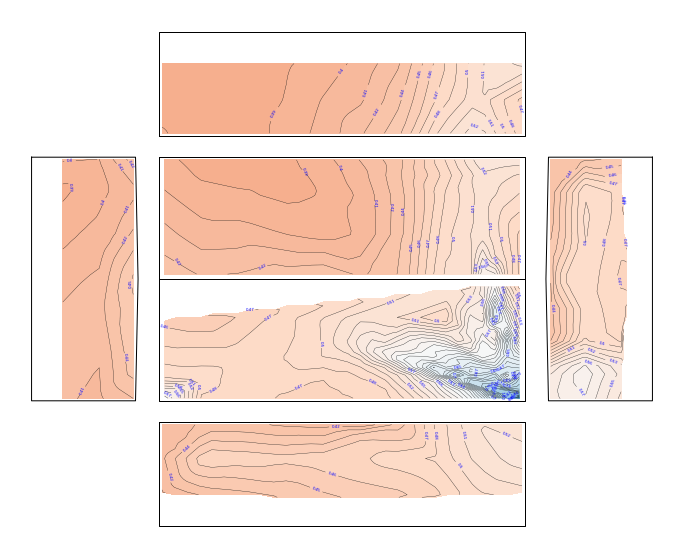

In [145]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
_ = LES_Cp.plotTapCpStatContour(fieldName='std',dxnIdx=None,ax=ax,fldRange=[0, 1.2], envelopeType='high')
_ = LES_Cp.plotEdges(ax=ax,showName=False)
# LES_Cp.plotTaps(ax=ax,)
ax.axis('off')
ax.axis('equal')
plt.show()


# if saveFigs:
#     fig.savefig(figDir+"Cp_"+fld+".svg",format='svg',dpi=1200, bbox_inches='tight')

Number of member bldgs: 2


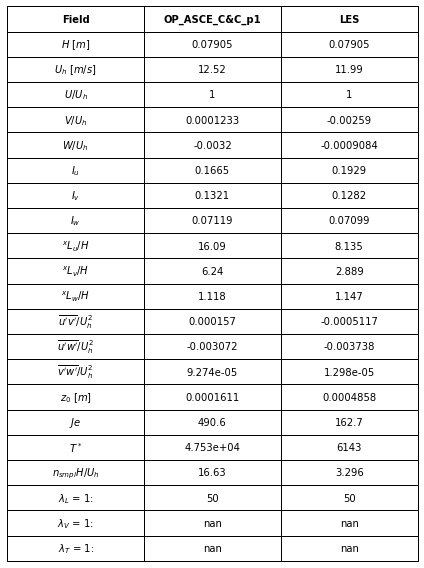

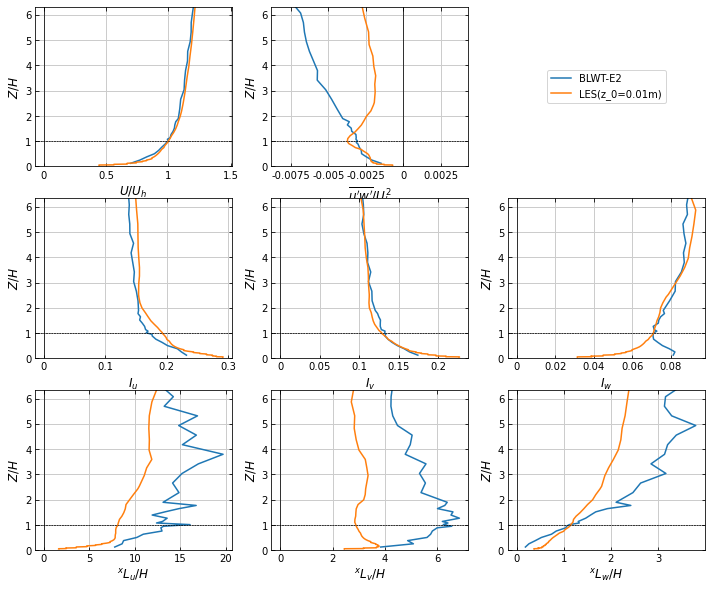

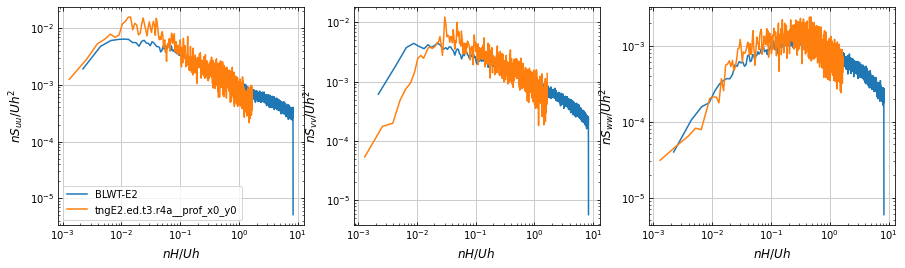

In [146]:
cps = wind.BldgCps([WT_cp, LES_Cp])
profs = wind.Profiles([WT_cp.profile, LES_Cp.profile])

cps.plotParamsTable()
_ = profs.plotProfile_basic2()
_ = profs.plotSpect()
# profs = wind.Profiles([wtVel_E2, lesVel_E2])
# profs.plotParamsTable()

In [151]:
# wind.measureError?
print(WT_cp.AoA)

[ 0. 20. 45. 70.]


### $C_p$ Plots

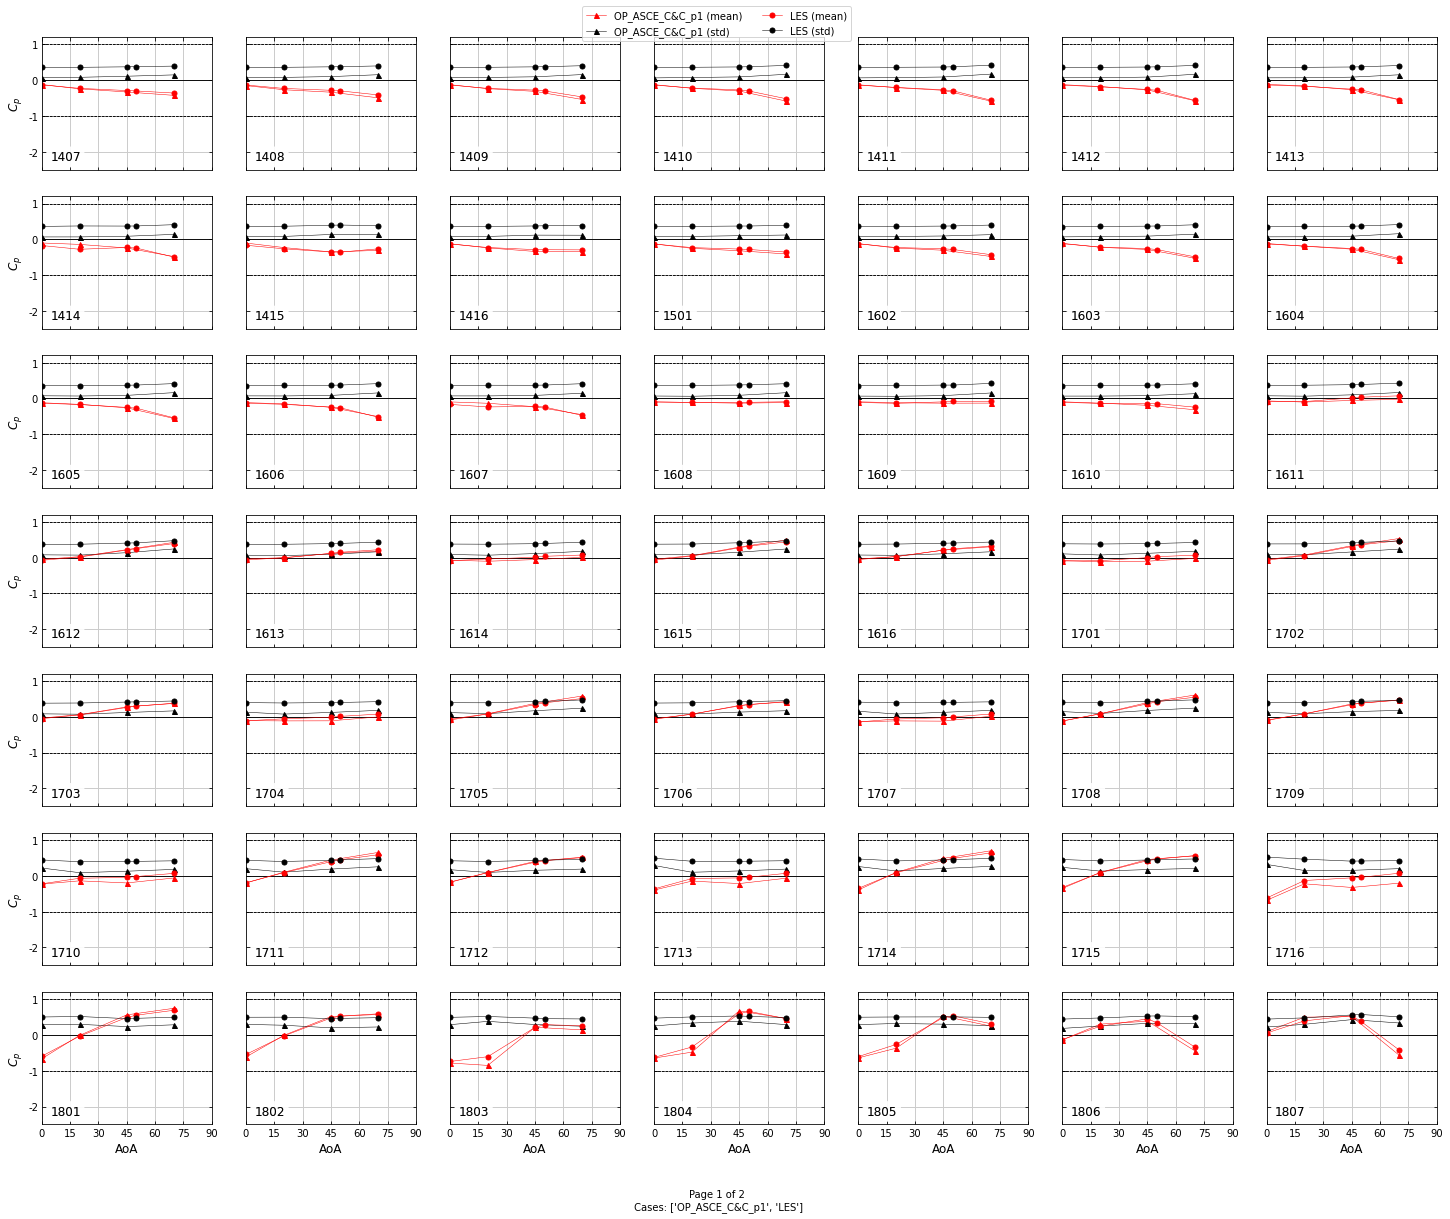

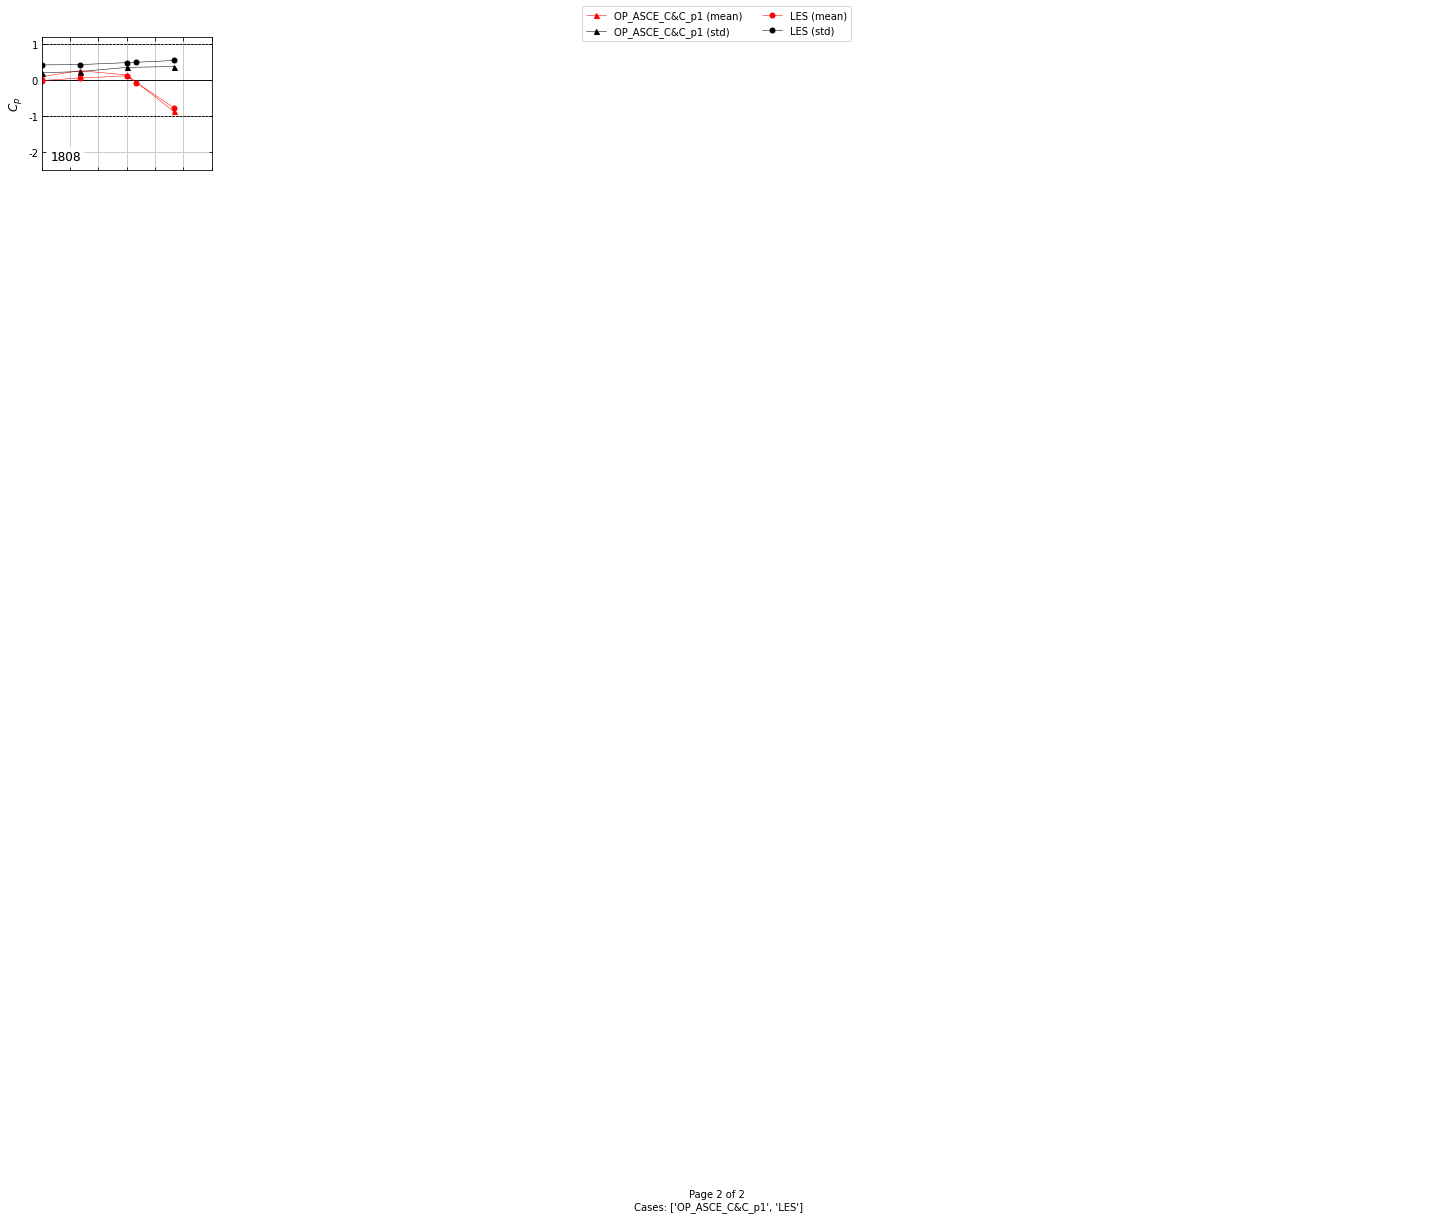

In [150]:
cols = ['r','k','b','g','m','r','k','b','g','m']
mrkrs = ['^','o','v','s','p','d','.','*','<','>','h']
# mrkrs = ['.','.','.','.','.','.','.','','','','']
ls=['-','-','-','-','-','-','-','-','-','-',]
kwargs_perFld = [[{ 'color':cols[f], 
                    'marker':mrkrs[b], 
                    'ls':ls[f],
                    'markersize':5,
                    'linewidth':0.5,
                    } for f in range(3)]
                    for b in range(cps.N_bldgs)] 

_,_ = cps.plotTapCpStatsPerAoA(fields=['mean','std'], tapsToPlot=bldg.tapNo[100:150],
        fldRange=[-2.5,1.2], pageNo_xy=(0.5,0.08), nCols=7, nRows=7, figsize=[25,20], xticks=np.arange(0,105,15),
                               kwargs_perFld=kwargs_perFld)


#### Local pressure

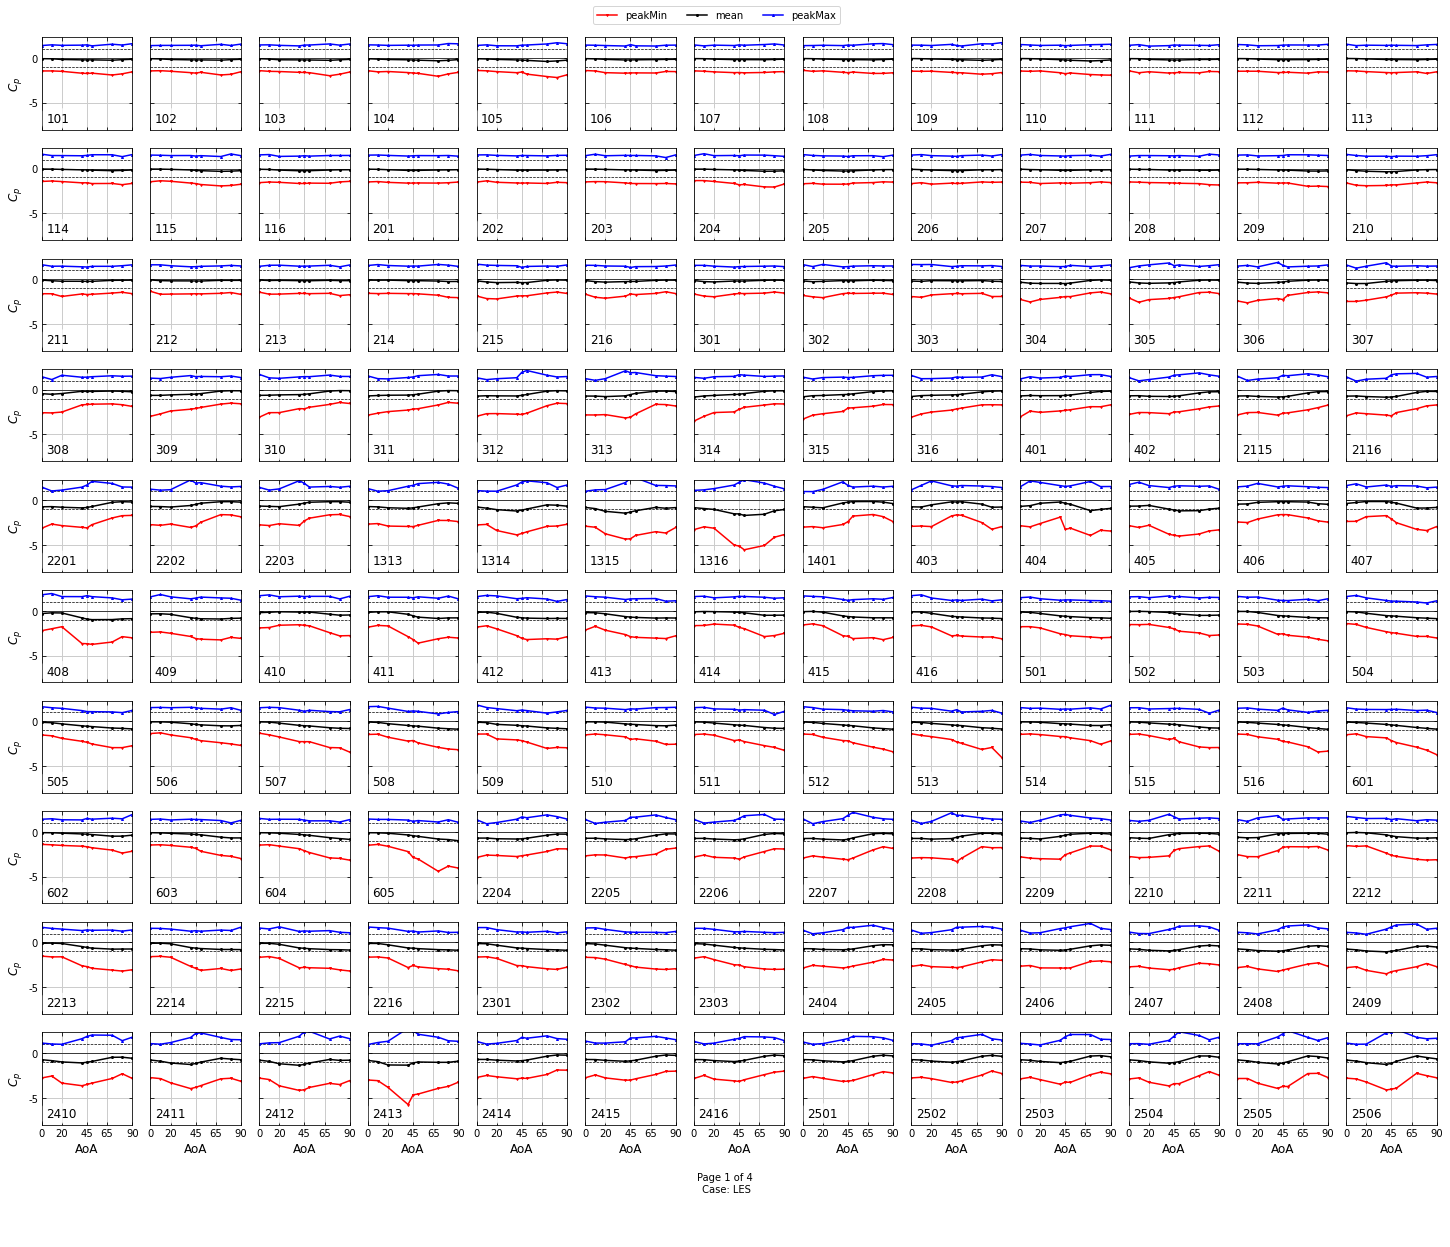

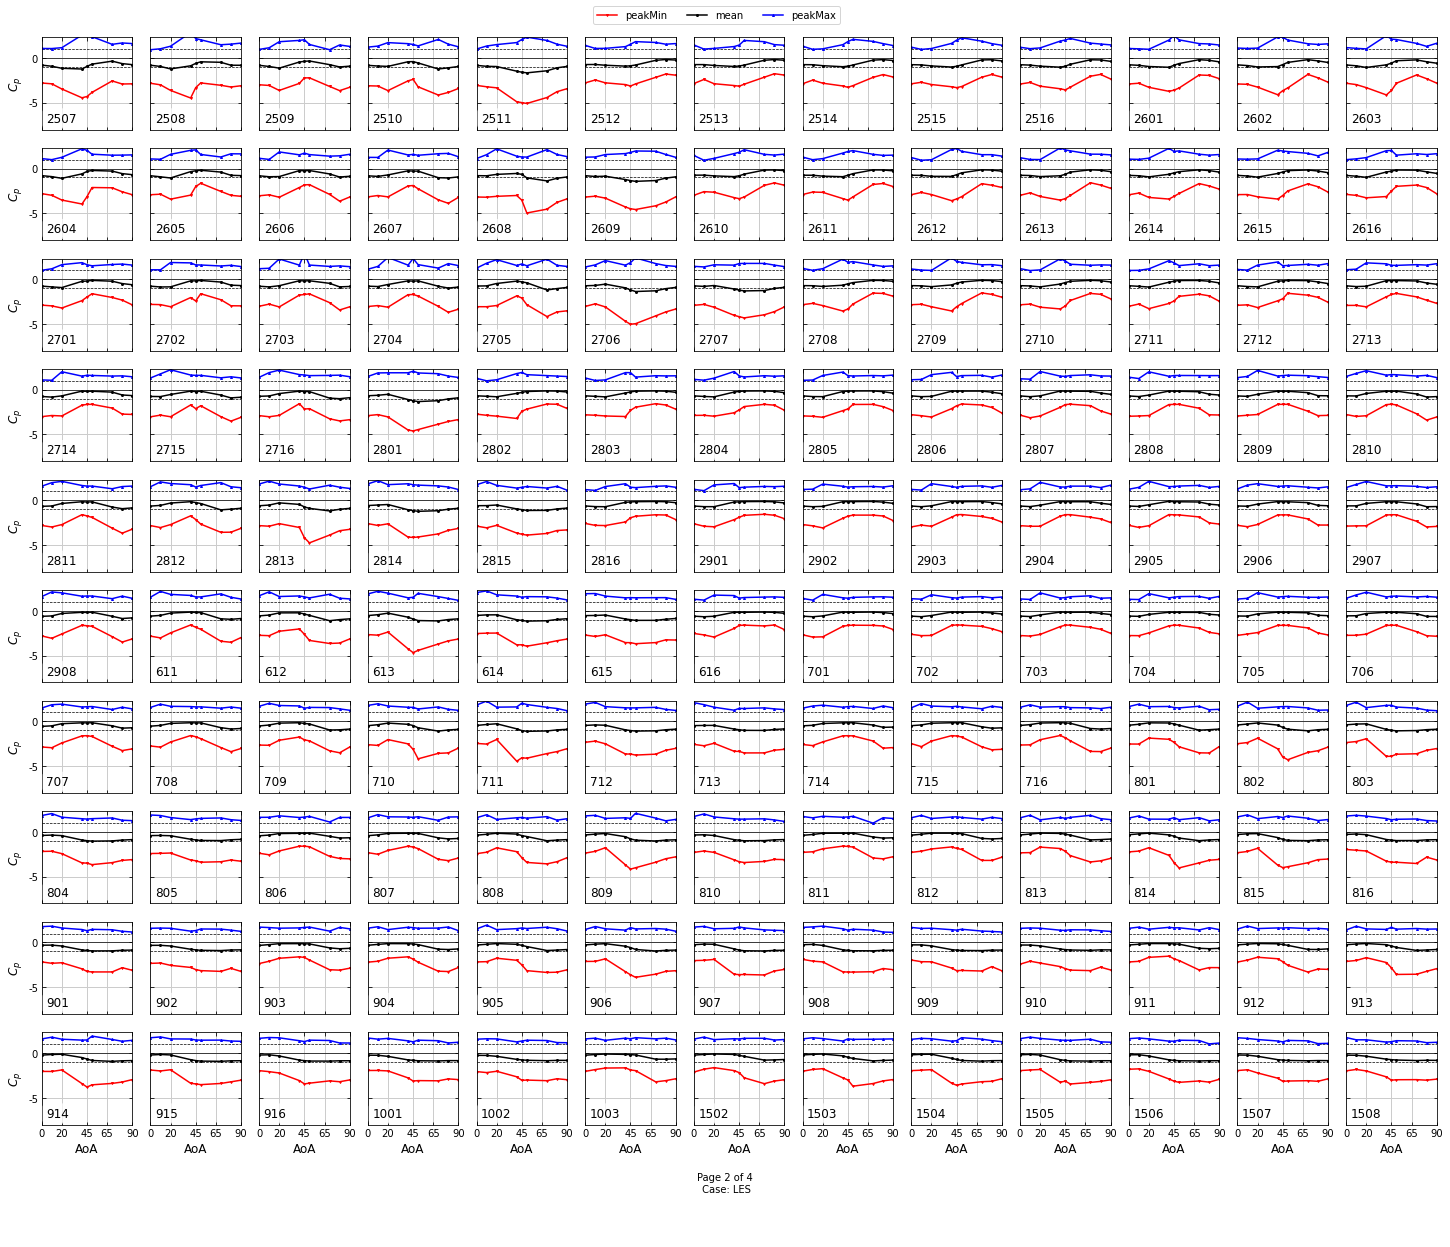

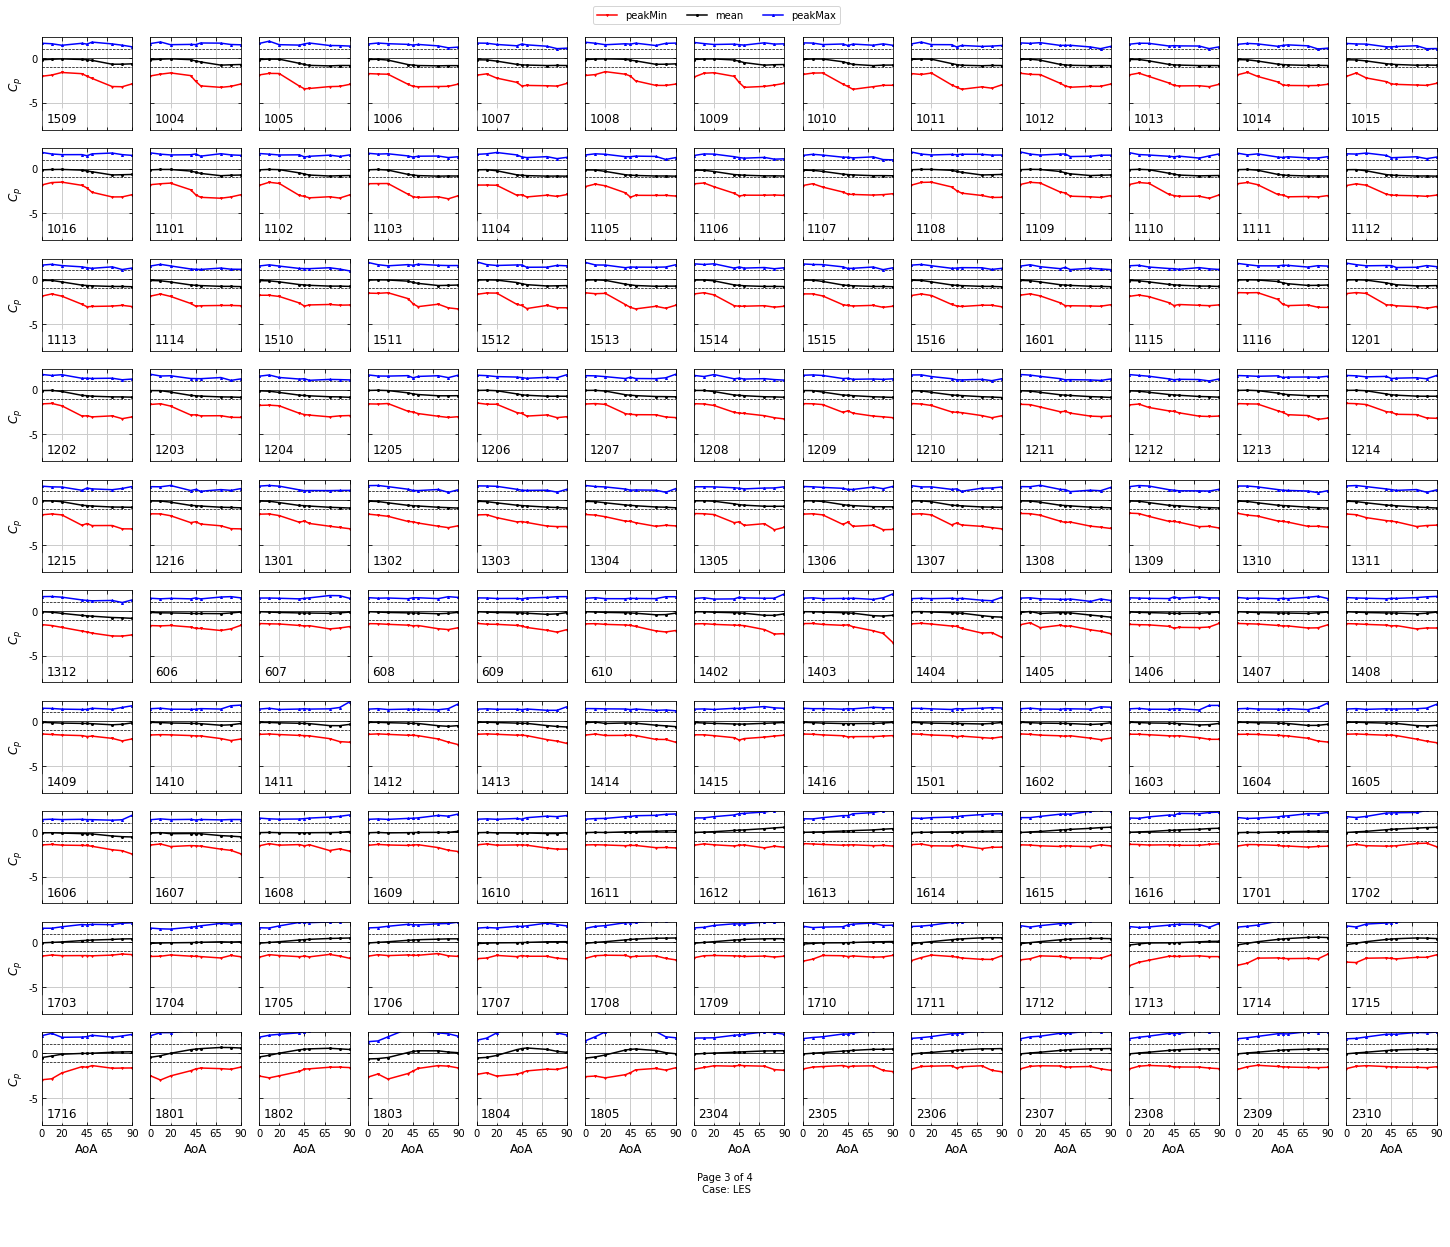

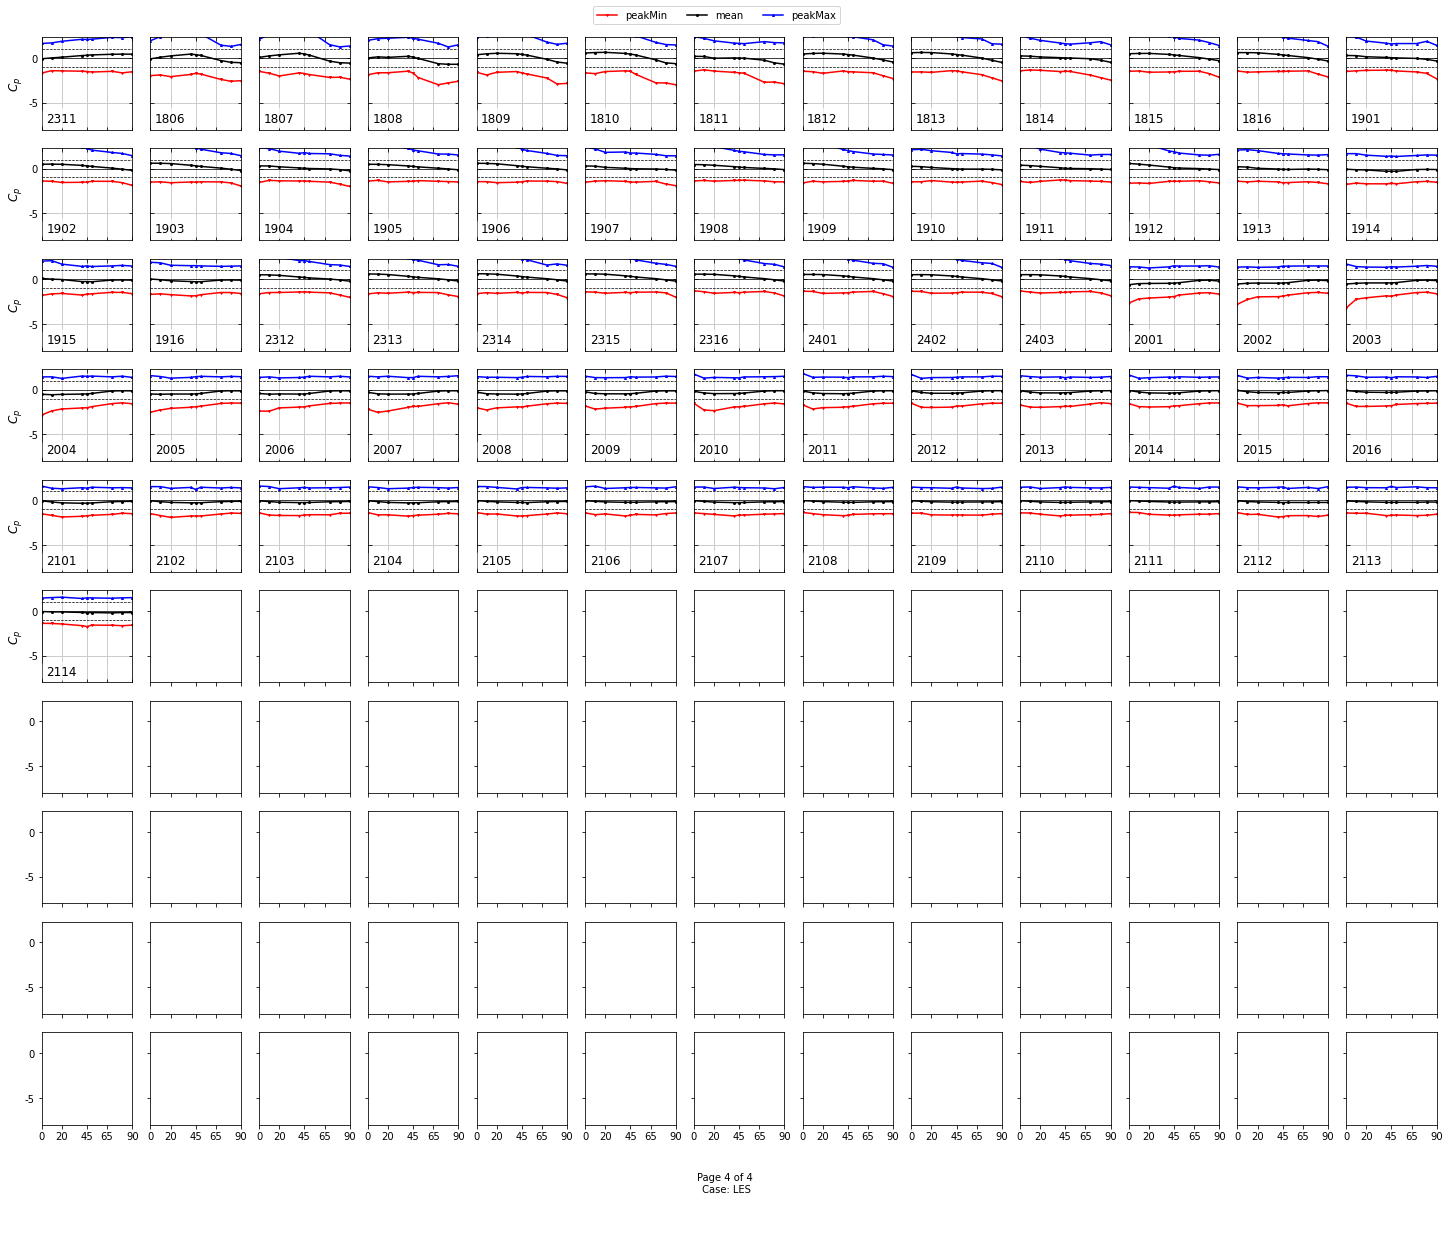

([<Figure size 1800x1440 with 130 Axes>,
  <Figure size 1800x1440 with 130 Axes>,
  <Figure size 1800x1440 with 130 Axes>,
  <Figure size 1800x1440 with 130 Axes>],
 [array([[<AxesSubplot:ylabel='$C_p$'>, <AxesSubplot:>, <AxesSubplot:>,
          <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
          <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
          <AxesSubplot:>, <AxesSubplot:>],
         [<AxesSubplot:ylabel='$C_p$'>, <AxesSubplot:>, <AxesSubplot:>,
          <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
          <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
          <AxesSubplot:>, <AxesSubplot:>],
         [<AxesSubplot:ylabel='$C_p$'>, <AxesSubplot:>, <AxesSubplot:>,
          <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
          <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
          <AxesSubplot:>, <AxesSubplot:>],
         [<AxesSubplot:ylabel='$C_p$'>, <AxesS

In [41]:
LES_Cp.plotTapCpStatsPerAoA(fldRange=[-8,2.3],#xticks=np.round(LES_Cp.AoA,0),
                            pageNo_xy=(0.5,0.06),nCols=13, figsize=[25,20])
# wtCp_tngE2.plotTapCpStatsPerAoA(fldRange=[-8,2.3],xticks=np.round(wtCp_tngE2.AoA,0),pageNo_xy=(0.5,0.06),nCols=13, figsize=[25,20])

# lesCp_E2.plotTapCpStatsPerAoA(fldRange=[-8,2.3],xticks=np.round(lesCp_E2.AoA,0),pageNo_xy=(0.5,0.06),nCols=13, figsize=[25,20])
# wtCp_tngE2.plotTapCpStatsPerAoA(fldRange=[-8,2.3],xticks=np.round(wtCp_tngE2.AoA,0),pageNo_xy=(0.5,0.06),nCols=13, figsize=[25,20])

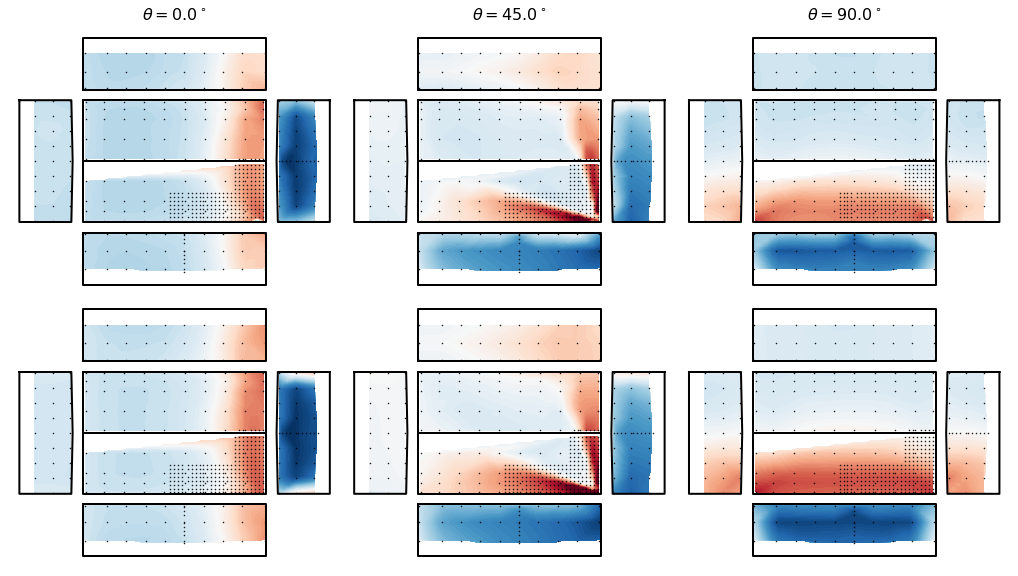

In [28]:
nrow, ncol = 2, N_AoA

fld = 'mean'
fldRange=[-1.6,0.8]

fig, axs = plt.subplots(nrow, ncol)
fig.set_figheight(5*nrow)
fig.set_figwidth(6*ncol)
fig.subplots_adjust(wspace=0.0, hspace=0.0)

for d,D in enumerate(lesCp_E2.AoA):
    ax = axs[0,d]
    wtCp_tngE2.plotTapCpStatContour(fieldName=fld,dxnIdx=d,ax=ax,fldRange=fldRange)
    wtCp_tngE2.plotEdges(ax=ax,showName=False)
    wtCp_tngE2.plotTaps(ax=ax,dotSz=1)
    ax.axis('off')
    ax.axis('equal')
    ax.set_title(r'$\theta='+str(np.round(D,0))+r'^\circ$',fontsize=16)

    ax = axs[1,d]
    lesCp_E2.plotTapCpStatContour(fieldName=fld,dxnIdx=d,ax=ax,fldRange=fldRange)
    lesCp_E2.plotEdges(ax=ax,showName=False)
    lesCp_E2.plotTaps(ax=ax,dotSz=1)
    ax.axis('off')
    ax.axis('equal')

# if saveFigs:
#     fig.savefig(figDir+"Cp_"+fld+".svg",format='svg',dpi=1200, bbox_inches='tight')

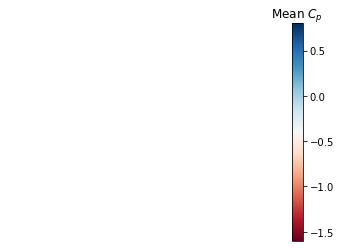

In [29]:

fig, ax = plt.subplots()
cmap = plt.get_cmap('RdBu')

plt.axis('off')
norm = plt.Normalize(*fldRange)

cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cb.ax.set_title(r"Mean $C_p$")
plt.show()
if saveFigs:
    fig.savefig(figDir+"Cp_"+fld+"_cmap.svg",format='svg',dpi=1200, bbox_inches='tight')


In [30]:
badTaps = np.array([1316, 1807, 2609,],dtype=int)
badIdx = np.where(np.in1d(bldg.tapNo, badTaps))[0]
mask = np.ones_like(bldg.tapNo, dtype=bool)
mask[badIdx] = False

fld = 'mean'
err_E2_mean = np.array([0,0,0],dtype=float)
for d in range(3):
    LES = lesCp_E2.CpStats[fld][d,mask]
    WT = wtCp_tngE2.CpStats[fld][d,mask]
    err_E2_mean[d] = np.mean(np.abs(LES-WT))/np.ptp(WT)

fld = 'std'
err_E2_std = np.array([0,0,0],dtype=float)
for d in range(3):
    LES = lesCp_E2.CpStats[fld][d,mask]
    WT = wtCp_tngE2.CpStats[fld][d,mask]
    err_E2_std[d] = np.mean(np.abs(LES-WT))/np.ptp(WT)

err_E2_peak = np.array([0,0,0],dtype=float)
for d in range(3):
    LES = np.append(lesCp_E2.CpStats['peakMax'][d,mask], lesCp_E2.CpStats['peakMin'][d,mask])
    WT = np.append(wtCp_tngE2.CpStats['peakMax'][d,mask], wtCp_tngE2.CpStats['peakMin'][d,mask])
    err_E2_peak[d] = np.mean(np.abs(LES-WT))/np.ptp(WT)


fld = 'mean'
err_E3_mean = np.array([0,0,0],dtype=float)
for d in range(3):
    LES = lesCp_E3.CpStats[fld][d,mask]
    WT = wtCp_tngE3.CpStats[fld][d,mask]
    err_E3_mean[d] = np.mean(np.abs(LES-WT))/np.ptp(WT)

fld = 'std'
err_E3_std = np.array([0,0,0],dtype=float)
for d in range(3):
    LES = lesCp_E3.CpStats[fld][d,mask]
    WT = wtCp_tngE3.CpStats[fld][d,mask]
    err_E3_std[d] = np.mean(np.abs(LES-WT))/np.ptp(WT)

err_E3_peak = np.array([0,0,0],dtype=float)
for d in range(3):
    LES = np.append(lesCp_E3.CpStats['peakMax'][d,mask], lesCp_E3.CpStats['peakMin'][d,mask])
    WT = np.append(wtCp_tngE3.CpStats['peakMax'][d,mask], wtCp_tngE3.CpStats['peakMin'][d,mask])
    err_E3_peak[d] = np.mean(np.abs(LES-WT))/np.ptp(WT)

err_E2_mean = np.transpose(err_E2_mean)*100
err_E2_std = np.transpose(err_E2_std)*100
err_E2_peak = np.transpose(err_E2_peak)*100
err_E3_mean = np.transpose(err_E3_mean)*100
err_E3_std = np.transpose(err_E3_std)*100
err_E3_peak = np.transpose(err_E3_peak)*100
print(err_E2_mean)
print(err_E2_std)
print(err_E2_peak)
print(err_E3_mean)
print(err_E3_std)
print(err_E3_peak)


[3.49643185 2.7647248  7.86227241]
[ 6.26053691  4.66153325 12.06137558]
[2.9359167  3.19540774 4.91870784]
[6.05108301 5.02768819 7.19497579]
[5.40095323 2.87046945 5.18646148]
[3.35942248 2.98130053 3.43554231]


C:\Users\Tsinu\AppData\Local\Temp\ipykernel_15476\3847678752.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([' ', r'Mean $C_p$', r'Std. $C_p$', r'Peak $C_p$'])
C:\Users\Tsinu\AppData\Local\Temp\ipykernel_15476\3847678752.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([' ', r'Mean $C_p$', r'Std. $C_p$', r'Peak $C_p$'])


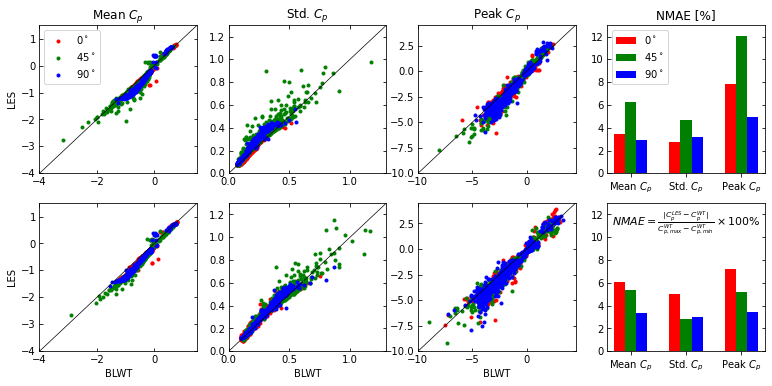

In [31]:
def forall(ax,lims):
    ax.tick_params(axis='both',direction='in',which='both',top=True,right=True)
    ax.plot([-100,100],[-100,100],'-k',lw=0.7)
    # ax.axis('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    # ax.set_xlabel('BLWT')
    # ax.set_ylabel('LES')
    


meanRng = [-4,1.5]
stdRng = [0,1.3]
peakRng = [-10,4.5]

fig = plt.figure(figsize=[13,6])
nrow,ncol = 2,4

ax = fig.add_subplot(nrow,ncol,1)
fld = 'mean'
ax.plot(wtCp_tngE2.CpStats[fld][0,mask], lesCp_E2.CpStats[fld][0,mask], '.r', label=r'$0^\circ$')
ax.plot(wtCp_tngE2.CpStats[fld][1,mask], lesCp_E2.CpStats[fld][1,mask], '.g', label=r'$45^\circ$')
ax.plot(wtCp_tngE2.CpStats[fld][2,mask], lesCp_E2.CpStats[fld][2,mask], '.b', label=r'$90^\circ$')
forall(ax,meanRng)
ax.legend()
ax.set_ylabel('LES')
ax.set_title(r'Mean $C_p$')

ax = fig.add_subplot(nrow,ncol,2)
fld = 'std'
ax.plot(wtCp_tngE2.CpStats[fld][0,mask], lesCp_E2.CpStats[fld][0,mask], '.r', label=r'$0^\circ$')
ax.plot(wtCp_tngE2.CpStats[fld][1,mask], lesCp_E2.CpStats[fld][1,mask], '.g', label=r'$45^\circ$')
ax.plot(wtCp_tngE2.CpStats[fld][2,mask], lesCp_E2.CpStats[fld][2,mask], '.b', label=r'$90^\circ$')
forall(ax,stdRng)
ax.set_title(r'Std. $C_p$')

ax = fig.add_subplot(nrow,ncol,3)
fld = 'peakMin'
ax.plot(wtCp_tngE2.CpStats[fld][0,mask], lesCp_E2.CpStats[fld][0,mask], '.r', label=r'E2-$0^\circ$')
ax.plot(wtCp_tngE2.CpStats[fld][1,mask], lesCp_E2.CpStats[fld][1,mask], '.g', label=r'E2-$45^\circ$')
ax.plot(wtCp_tngE2.CpStats[fld][2,mask], lesCp_E2.CpStats[fld][2,mask], '.b', label=r'E2-$90^\circ$')
fld = 'peakMax'
ax.plot(wtCp_tngE2.CpStats[fld][0,mask], lesCp_E2.CpStats[fld][0,mask], '.r', label=r'E2-$0^\circ$')
ax.plot(wtCp_tngE2.CpStats[fld][1,mask], lesCp_E2.CpStats[fld][1,mask], '.g', label=r'E2-$45^\circ$')
ax.plot(wtCp_tngE2.CpStats[fld][2,mask], lesCp_E2.CpStats[fld][2,mask], '.b', label=r'E2-$90^\circ$')
forall(ax,peakRng)
ax.set_title(r'Peak $C_p$')



ax = fig.add_subplot(nrow,ncol,4)
errNames = np.array([1.0, 2.0, 3.0],dtype=float)
ax.bar(errNames-0.2, err_E2_mean, width=0.2, color='r', label=r'$0^\circ$') #, hatch="/", hatch_scale=0.5)
ax.bar(errNames, err_E2_std, width=0.2, color='g', label=r'$45^\circ$') #, hatch="\\", hatch_scale=0.5)
ax.bar(errNames+0.2, err_E2_peak, width=0.2, color='b', label=r'$90^\circ$') #, hatch="+", hatch_scale=0.5)
ax.tick_params(axis='y',direction='in',which='both',right=True)
ax.legend()
ax.set_ylim([0, 13.0])
ax.set_title('NMAE [%]')
ax.set_xticklabels([' ', r'Mean $C_p$', r'Std. $C_p$', r'Peak $C_p$'])




ax = fig.add_subplot(nrow,ncol,5)
fld = 'mean'
ax.plot(wtCp_tngE3.CpStats[fld][0,mask], lesCp_E3.CpStats[fld][0,mask], '.r', label=r'E2-$0^\circ$')
ax.plot(wtCp_tngE3.CpStats[fld][1,mask], lesCp_E3.CpStats[fld][1,mask], '.g', label=r'E2-$45^\circ$')
ax.plot(wtCp_tngE3.CpStats[fld][2,mask], lesCp_E3.CpStats[fld][2,mask], '.b', label=r'E2-$90^\circ$')
forall(ax,meanRng)
ax.set_xlabel('BLWT')
ax.set_ylabel('LES')

ax = fig.add_subplot(nrow,ncol,6)
fld = 'std'
ax.plot(wtCp_tngE3.CpStats[fld][0,mask], lesCp_E3.CpStats[fld][0,mask], '.r', label=r'E2-$0^\circ$')
ax.plot(wtCp_tngE3.CpStats[fld][1,mask], lesCp_E3.CpStats[fld][1,mask], '.g', label=r'E2-$45^\circ$')
ax.plot(wtCp_tngE3.CpStats[fld][2,mask], lesCp_E3.CpStats[fld][2,mask], '.b', label=r'E2-$90^\circ$')
forall(ax,stdRng)
ax.set_xlabel('BLWT')

ax = fig.add_subplot(nrow,ncol,7)
fld = 'peakMin'
ax.plot(wtCp_tngE3.CpStats[fld][0,mask], lesCp_E3.CpStats[fld][0,mask], '.r', label=r'E2-$0^\circ$')
ax.plot(wtCp_tngE3.CpStats[fld][1,mask], lesCp_E3.CpStats[fld][1,mask], '.g', label=r'E2-$45^\circ$')
ax.plot(wtCp_tngE3.CpStats[fld][2,mask], lesCp_E3.CpStats[fld][2,mask], '.b', label=r'E2-$90^\circ$')
fld = 'peakMax'
ax.plot(wtCp_tngE3.CpStats[fld][0,mask], lesCp_E3.CpStats[fld][0,mask], '.r', label=r'E2-$0^\circ$')
ax.plot(wtCp_tngE3.CpStats[fld][1,mask], lesCp_E3.CpStats[fld][1,mask], '.g', label=r'E2-$45^\circ$')
ax.plot(wtCp_tngE3.CpStats[fld][2,mask], lesCp_E3.CpStats[fld][2,mask], '.b', label=r'E2-$90^\circ$')
forall(ax,peakRng)
ax.set_xlabel('BLWT')


ax = fig.add_subplot(nrow,ncol,8)
errNames = np.array([1.0, 2.0, 3.0],dtype=float)
ax.bar(errNames-0.2, err_E3_mean, width=0.2, color='r', label=r'$0^\circ$') #, hatch="/", hatch_scale=0.5)
ax.bar(errNames, err_E3_std, width=0.2, color='g', label=r'$45^\circ$') #, hatch="\\", hatch_scale=0.5)
ax.bar(errNames+0.2, err_E3_peak, width=0.2, color='b', label=r'$90^\circ$') #, hatch="+", hatch_scale=0.5)
ax.text(2.0, 11.0, r'$NMAE = \frac{\left| C_p^{LES} - C_p^{WT} \right|}{C_{p,max}^{WT} - C_{p,min}^{WT}}\times 100\%$',
        ha='center',fontsize=11)
ax.tick_params(axis='y',direction='in',which='both',right=True)
ax.set_ylim([0, 13.0])
ax.set_xticklabels([' ', r'Mean $C_p$', r'Std. $C_p$', r'Peak $C_p$'])


if saveFigs:
    fig.savefig(figDir+"Cp_WTvsLES.svg",format='svg',dpi=1200, bbox_inches='tight')

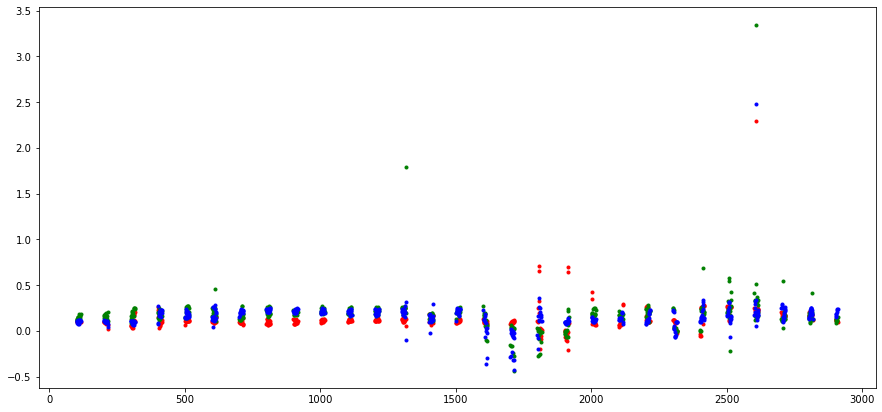

In [32]:


fig = plt.figure(figsize=[15,7])
nrow,ncol = 1,1

ax = fig.add_subplot(nrow,ncol,1)
fld = 'mean'
# ax.plot(wtCp_tngE2.tapNo, wtCp_tngE2.CpStats[fld][0,:] - lesCp_E2.CpStats[fld][0,:], '.r', label=r'E2-$0^\circ$')
# ax.plot(wtCp_tngE2.tapNo, wtCp_tngE2.CpStats[fld][1,:] - lesCp_E2.CpStats[fld][1,:], '.g', label=r'E2-$45^\circ$')
# ax.plot(wtCp_tngE2.tapNo, wtCp_tngE2.CpStats[fld][2,:] - lesCp_E2.CpStats[fld][2,:], '.b', label=r'E2-$90^\circ$')

ax.plot(wtCp_tngE3.tapNo, wtCp_tngE3.CpStats[fld][0,:] - lesCp_E3.CpStats[fld][0,:], '.r', label=r'E2-$0^\circ$')
ax.plot(wtCp_tngE3.tapNo, wtCp_tngE3.CpStats[fld][1,:] - lesCp_E3.CpStats[fld][1,:], '.g', label=r'E2-$45^\circ$')
ax.plot(wtCp_tngE3.tapNo, wtCp_tngE3.CpStats[fld][2,:] - lesCp_E3.CpStats[fld][2,:], '.b', label=r'E2-$90^\circ$')

# ax.set_xlim([2599, 2617])
# forall(ax,meanRng)
# ax.set_ylabel('LES')


#### Area averaged load

In [33]:
# ncol, nrow = N_AoA*2, len(bldg[0].nominalPanelAreas)

# fld = 'peakMin'
# fldRange=[-8,2]

# fig, axs = plt.subplots(nrow, ncol)
# fig.set_figheight(6*nrow)
# fig.set_figwidth(6*ncol)
# fig.subplots_adjust(wspace=0.0, hspace=0.0)

# for a,A in enumerate(bldg[0].nominalPanelAreas):
#     for d,D in enumerate(lesCp_E2.AoA):

#         ax = axs[a,d*2]
#         wtCp_tngE2.plotPanelCpStatContour(fieldName=fld,dxnIdx=d,aIdx=a,ax=ax,fldRange=fldRange)
#         wtCp_tngE2.plotEdges(ax=ax,showName=False)
#         wtCp_tngE2.plotZones(ax=ax)
#         ax.axis('off')
#         ax.axis('equal')
#         if a == 0:
#             ax.set_title(r'BLWT, $\theta='+str(np.round(D,0))+r'^\circ$',fontsize=16)

#         ax = axs[a,d*2+1]
#         lesCp_E2.plotPanelCpStatContour(fieldName=fld,dxnIdx=d,aIdx=a,ax=ax,fldRange=fldRange)
#         lesCp_E2.plotEdges(ax=ax,showName=False)
#         wtCp_tngE2.plotZones(ax=ax)
#         ax.axis('off')
#         ax.axis('equal')
#         if a == 0:
#             ax.set_title(r'LES, $\theta='+str(np.round(D,0))+r'^\circ$',fontsize=16)
# if saveFigs:
#     fig.savefig(figDir+"areaAvgCp_"+fld+".svg",format='svg',dpi=1200, bbox_inches='tight')

In [34]:
NBCC_A_min = [
            [0.1, 1, 10, 100], # c
            [0.1, 2.2, 10, 100], # s
            [0.1, 1, 10, 100], # r
            ]
NBCC_CpCg_min = np.array([
            [-5, -5, -4, -4],
            [-3.6, -3.6, -2.6, -2.6],
            [-2.45, -2.45, -2, -2]
            ],dtype=float)
NBCC_A_max = [0.1, 1, 10, 100]
NBCC_CpCg_max = np.array([0.75, 0.75, 0.5, 0.5],dtype=float)

ft2m_sq = 0.3048**2

ASCE_A_min = np.array([
            [0.1, 10, 500, 2000], # 3
            [0.1, 10, 500, 2000], # 2
            [0.1, 10, 500, 2000], # 1
            [0.1, 100, 500, 2000], # 1'
            ],dtype=float)*ft2m_sq
ASCE_GCp_min = np.array([
            [-3.2, -3.2, -1.4, -1.4], # 3
            [-2.3, -2.3, -1.4, -1.4], # 2
            [-1.7, -1.7, -1.0, -1.0], # 1
            [-0.9, -0.9, -0.4, -0.4], # 1'
            ],dtype=float)
ASCE_A_max = np.array([0.1, 100, 500, 2000],dtype=float)*ft2m_sq
ASCE_GCp_max = np.array([0.3, 0.3, 0.2, 0.2],dtype=float)


In [35]:
from typing import List,Literal,Dict,Tuple,Any

def CpStatsAreaAvgCollected(self, mixNominalAreas=False, 
                    envelope:Literal['max','min','none']='none', 
                    extremesPerNominalArea:Literal['max','min','none']='none'):
    # [Nfaces][Nzones][Narea][Nflds][N_AoA,Npanels]
    zNames = []
    for z, zn in enumerate(self.zoneDict):
        zNames.append(self.zoneDict[zn][0]+'_'+self.zoneDict[zn][1])
    CpAavg = self.zoneDict
    for zm, zone_m in enumerate(CpAavg):
        if mixNominalAreas:
            CpAavg[zone_m][2] = {}
            for _, fld in enumerate(self.CpStatsAreaAvg[0][zm][0]):
                CpAavg[zone_m][2][fld] = None                
        else:
            CpAavg[zone_m][2] = []
            for a, _ in enumerate(self.faces[0].nominalPanelAreas):
                CpAavg[zone_m][2].append({})
                for _, fld in enumerate(self.CpStatsAreaAvg[0][zm][0]):
                    CpAavg[zone_m][2][a][fld] = None

    def envelopeFld(fld): # assumes all fields have the AoA as the first index
        if envelope == 'max':
            return np.max(fld,axis=0,keepdims=True) 
        elif envelope == 'min':
            return np.min(fld,axis=0,keepdims=True)
        elif envelope == 'none':
            return fld

    def extremePerArea(fld):
        if extremesPerNominalArea == 'max':
            return np.max(fld,axis=1,keepdims=True) 
        elif extremesPerNominalArea == 'min':
            return np.min(fld,axis=1,keepdims=True)
        elif extremesPerNominalArea == 'none':
            return fld

    for f,fc in enumerate(self.faces):
        for z,zone in enumerate(fc.zoneDict):
            zIdx = zNames.index(fc.zoneDict[zone][0]+'_'+fc.zoneDict[zone][1])
            for a,_ in enumerate(fc.nominalPanelAreas):
                for _, fld in enumerate(self.CpStatsAreaAvg[f][z][a]):
                    if mixNominalAreas:
                        if CpAavg[zIdx][2][fld] is None:
                            CpAavg[zIdx][2][fld] = {}
                            CpAavg[zIdx][2][fld] = envelopeFld(self.CpStatsAreaAvg[f][z][a][fld])
                        else:
                            CpAavg[zIdx][2][fld] = np.concatenate((CpAavg[zIdx][2][fld], envelopeFld(self.CpStatsAreaAvg[f][z][a][fld])), axis=1)
                    else:
                        if CpAavg[zIdx][2][a][fld] is None:
                            CpAavg[zIdx][2][a][fld] = {}
                            CpAavg[zIdx][2][a][fld] = envelopeFld(self.CpStatsAreaAvg[f][z][a][fld])
                        else:
                            CpAavg[zIdx][2][a][fld] = np.concatenate((CpAavg[zIdx][2][a][fld], envelopeFld(self.CpStatsAreaAvg[f][z][a][fld]) ), axis=1)
    if not extremesPerNominalArea == 'none' and not mixNominalAreas:
        __CpAavg = CpAavg
        CpAavg = self.zoneDict
        for zm, zone_m in enumerate(CpAavg):
            CpAavg[zone_m][2] = {}
            for _, fld in enumerate(self.CpStatsAreaAvg[0][zm][0]):
                CpAavg[zone_m][2][fld] = np.zeros_like(self.faces[0].nominalPanelAreas)
                for a, _ in enumerate(self.faces[0].nominalPanelAreas):
                    CpAavg[zone_m][2][fld][a] = np.squeeze(extremePerArea(__CpAavg[zone_m][2][a][fld]))
    return CpAavg

TypeError: float() argument must be a string or a number, not 'NoneType'

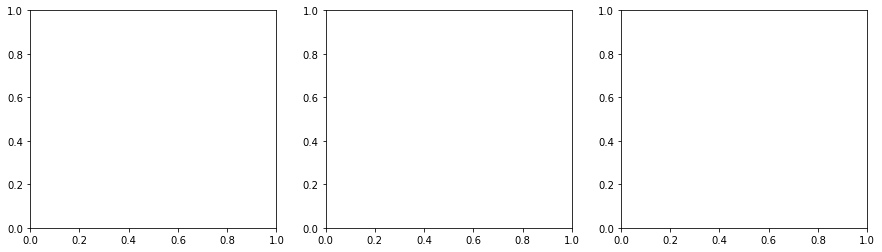

In [36]:
A = np.array(bldg[0].nominalPanelAreas)
A = np.multiply(A, np.power(1/bldg.lScl,2))
durstFactor = 1.53**2
ASCE_directionalityFactor = 0.85
fact_NBCC_2_ASCE = (1/ASCE_directionalityFactor)*(1/durstFactor)

nrow, ncol = 1, 3
fig, axs = plt.subplots(nrow, ncol)
fig.set_figheight(4*nrow)
fig.set_figwidth(5*ncol)

titles = ['Corner', 'Edge', 'Field']
for z in range(ncol):
    ax = axs[z]
    cpAvg = CpStatsAreaAvgCollected(lesCp_E2, envelope='low',extremesPerNominalArea='low')
    ax.semilogx(A, cpAvg[z][2]['peakMin']*fact_NBCC_2_ASCE,'or',label='LES')
    cpAvg = CpStatsAreaAvgCollected(wtCp_tngE2,envelope='low',extremesPerNominalArea='low')
    ax.semilogx(A, cpAvg[z][2]['peakMin']*fact_NBCC_2_ASCE,'db',label='BLWT')
    ax.semilogx(NBCC_A_min[z], NBCC_CpCg_min[z]*fact_NBCC_2_ASCE,'-k',lw=2,label='NBCC-2020')
    ax.semilogx(ASCE_A_min[z], ASCE_GCp_min[z],'--k',lw=2,label='ASCE 7-22')
    if z == 2:
        ax.semilogx(ASCE_A_min[z+1], ASCE_GCp_min[z+1],'--k',lw=2)

    cpAvg = lesCp_E2.CpStatsAreaAvgCollected(envelope='high',extremesPerNominalArea='high')
    ax.semilogx(A, cpAvg[z][2]['peakMax']*fact_NBCC_2_ASCE,'or')
    cpAvg = wtCp_tngE2.CpStatsAreaAvgCollected(envelope='high',extremesPerNominalArea='high')
    ax.semilogx(A, cpAvg[z][2]['peakMax']*fact_NBCC_2_ASCE,'db')
    ax.semilogx(NBCC_A_max, NBCC_CpCg_max*fact_NBCC_2_ASCE,'-k',lw=2)
    ax.semilogx(ASCE_A_max, ASCE_GCp_max,'--k',lw=2,)


    ax.set_ylim([-6,1])
    ax.set_xlim([0.1,100])
    ax.tick_params(axis='both',direction='in',which='both',top=True,right=True)
    ax.invert_yaxis()
    ax.grid('both')
    ax.set_ylabel(r'$GC_p$')
    ax.set_xlabel(r'A [$m^2$]')
    ax.set_title(titles[z])
    if z == 2:
        ax.legend()

if saveFigs:
    fig.savefig(figDir+"areaAvgGCp_LESvsWTvsCode.svg",format='svg',dpi=1200, bbox_inches='tight')

In [ ]:
print(lesCp_E2.CpStatsAreaAvgCollected(envelope='low',extremesPerNominalArea='low'))